In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install colorcet

     |████████████████████████████████| 1.6MB 3.4MB/s 


In [3]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from IPython.display import display
from sklearn.manifold import TSNE
from sklearn import svm
#For creating a heat map of the US
#Reference: https://www.kaggle.com/oilcorner/wildfire-visualization-heat-maps-literally
import colorcet as cc
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, LogColorMapper, ColorBar, LogTicker

In [4]:
conn = sqlite3.connect('drive/My Drive/CaseStudy1/FPA_FOD_20170508.sqlite')

In [92]:
df = pd.read_sql_query("SELECT * FROM fires;", conn)

In [6]:
df.head()

OBJECTID  ...                                              Shape
0         1  ...  b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1         2  ...  b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2         3  ...  b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3         4  ...  b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4         5  ...  b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...

[5 rows x 39 columns]

In [ ]:
#Statistically analyzing the dataset
print('Column names for this datset are: \n',df.columns)
print('Dataset Shape is: ', df.shape, '\n')
print(df.info())

Column names for this datset are: 
 Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')
Dataset Shape is:  (1880465, 39) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 39 columns):
 #   Column                      Dtype  
---  ------                 

*OBSERVATIONS*:
***After analysing the datset, we now know that there is a total of 39 columns out of which only 12 of them are of numeric data type (8 float + 4 int), rest all of them (27) are objects which we have to convert into numerical forms for feeding into the machine learning models.***

There are a lot of ID features which are just unique identification numbers/sequences assigend to each fire department wise. Therefore they would not contibute into predicting the size of future fires. Such features can be removed as they are just increasing the dimensionality of our datset and not adding much value for it. We would perform a detailed analysis on each of them before deciding to remove them.

'FIRE_SIZE_CLASS' feature will be used as our class label.

Analysing each feature individually for it:


In [7]:
#Class Labels: FIRE_SIZE_CLASS     
#First analysing the feature which would be used as the class label.
print('Unique values for Column FIRE_SIZE_CLASS are: ', df.FIRE_SIZE_CLASS.unique())
print('Length of Unique values for Column FIRE_SIZE_CLASS are: ', len(df.FIRE_SIZE_CLASS.unique()))
#Check for null values
bool_series = pd.isnull(df['FIRE_SIZE_CLASS'])
print('Number of null entries for Column FIRE_SIZE_CLASS are: ', len(df[bool_series]))   

Unique values for Column FIRE_SIZE_CLASS are:  ['A' 'B' 'G' 'C' 'D' 'F' 'E']
Length of Unique values for Column FIRE_SIZE_CLASS are:  7
Number of null entries for Column FIRE_SIZE_CLASS are:  0


In [8]:
#Since it is an Object data type, converting it into numeric form for further analysis
df['FIRE_SIZE_CLASS'] = df['FIRE_SIZE_CLASS'].map({'A': 1, 'B': 2, 'C':3, 'D':4, 'E': 5, 'F': 6,'G': 7}) 
df['FIRE_SIZE_CLASS'].astype('int64')

0          1
1          1
2          1
3          1
4          1
          ..
1880460    1
1880461    1
1880462    1
1880463    2
1880464    1
Name: FIRE_SIZE_CLASS, Length: 1880465, dtype: int64

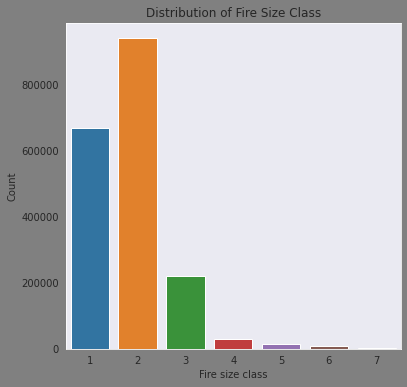

In [ ]:
#Graphical Analysis to check the distribution
plt.figure(figsize=(6,6), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='FIRE_SIZE_CLASS', data = df) 
plt.xlabel('Fire size class')
plt.title('Distribution of Fire Size Class')
plt.ylabel('Count')
plt.show()

##Here different claases of fire size indicate:

1. 1/A: Fire Spread Area between 0-0.25 acres
2. 2/B: Fire Spread Area between 0.26-9.9 acres
3. 3/C: Fire Spread Area between 10.0-99.9 acres
4. 4/D: Fire Spread Area between 100-299 acres
5. 5/E: Fire Spread Area between 300-999 acres
6. 6/F: Fire Spread Area between 1000-4999 acres
7. 7/G: 5000+ acres


The dataset is highly imbalanced with maximum count of forest fires lying in Class 2. Class 7 has the minimum fire incidents. Exact number of incidents for each class cab ne obtained in the cell below:


In [ ]:
#Checking count of each forest fire class
df['FIRE_SIZE_CLASS'].value_counts()

2    939376
1    666919
3    220077
4     28427
5     14107
6      7786
7      3773
Name: FIRE_SIZE_CLASS, dtype: int64

In [ ]:
#Feature 1: OBJECTID     
print('Unique values for Column OBJECTID are: ', df.OBJECTID.unique())
print('Length of Unique values for Column OBJECTID are: ', len(df.OBJECTID.unique()))
#Check for null values
bool_series = pd.isnull(df['OBJECTID'])
print('Number of null entries for Column OBJECTID are: ', len(df[bool_series]))               

Unique values for Column OBJECTID are:  [      1       2       3 ... 1880463 1880464 1880465]
Length of Unique values for Column OBJECTID are:  1880465
Number of null entries for Column OBJECTID are:  0


As we can see this column has a unique value for each row, therefore it is just an identifier. So removing this column from our final dataset

In [9]:
del df['OBJECTID']
df.shape

(1880465, 38)

Similarly the next two columns are also IDs, therefore having a look at their unique values before removing them

In [ ]:
#Feature 2: FOD_ID     
print('Unique values for Column FOD_ID are: ', df.FOD_ID.unique())
print('Length of Unique values for Column FOD_ID are: ', len(df.FOD_ID.unique()))
#Check for null values
bool_series = pd.isnull(df['FOD_ID'])
print('Number of null entries for Column FOD_ID are: ', len(df[bool_series]))   

#Feature 3: FPA_ID     
print('\n Unique values for Column FPA_ID are: ', df.FPA_ID.unique())
print('Length of Unique values for Column FPA_ID are: ', len(df.FPA_ID.unique()))
#Check for null values
bool_series = pd.isnull(df['FPA_ID'])
print('Number of null entries for Column FPA_ID are: ', len(df[bool_series]))   

Unique values for Column FOD_ID are:  [        1         2         3 ... 300348375 300348377 300348399]
Length of Unique values for Column FOD_ID are:  1880465
Number of null entries for Column FOD_ID are:  0

 Unique values for Column FPA_ID are:  ['FS-1418826' 'FS-1418827' 'FS-1418835' ... '2015CAIRS28364460'
 '2015CAIRS29218079' '2015CAIRS26733926']
Length of Unique values for Column FPA_ID are:  1880462
Number of null entries for Column FPA_ID are:  0


Since these two values are unique for each row, therefore they can't be a feature used for differentiating fire classes, therefore removing them from the final table too.

In [10]:
del df['FOD_ID']
del df['FPA_ID']
df.shape

(1880465, 36)

In [ ]:
#Feature 4: SOURCE_SYSTEM_TYPE
print('Unique values for Column SOURCE_SYSTEM_TYPE are: ', df.SOURCE_SYSTEM_TYPE.unique())
print('Length of Unique values for Column SOURCE_SYSTEM_TYPE are: ', len(df.SOURCE_SYSTEM_TYPE.unique()))
#Check for null values
bool_series = pd.isnull(df['SOURCE_SYSTEM_TYPE'])
print('Number of null entries for Column SOURCE_SYSTEM_TYPE are: ', len(df[bool_series]))

Unique values for Column SOURCE_SYSTEM_TYPE are:  ['FED' 'NONFED' 'INTERAGCY']
Length of Unique values for Column SOURCE_SYSTEM_TYPE are:  3
Number of null entries for Column SOURCE_SYSTEM_TYPE are:  0


This feature consists of just 3 unique values, it can be useful in differentiating forest fire classes. 
The feature can be converted into numerical feature either manually or using label encoders.
First converting the feature into a numeric form using label encoders so that we could perform univariate analysis on it to understand the feature better.


In [11]:
label_encoder = preprocessing.LabelEncoder() 

In [12]:
#using Label encoders for this 
df['SOURCE_SYSTEM_TYPE'] = label_encoder.fit_transform(df['SOURCE_SYSTEM_TYPE']) 
df['SOURCE_SYSTEM_TYPE'].astype('int64')

0          0
1          0
2          0
3          0
4          0
          ..
1880460    2
1880461    2
1880462    2
1880463    2
1880464    2
Name: SOURCE_SYSTEM_TYPE, Length: 1880465, dtype: int64

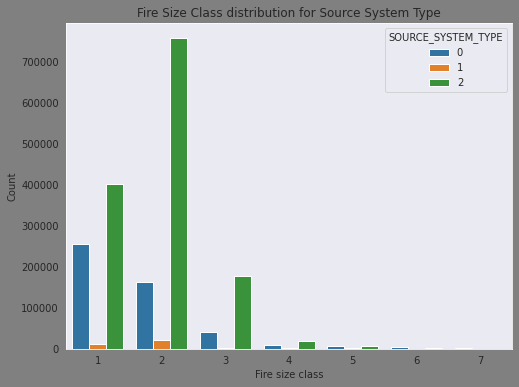

In [ ]:
#Graphical Analysis to check the distribution
plt.figure(figsize=(8,6), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='FIRE_SIZE_CLASS', hue='SOURCE_SYSTEM_TYPE', data = df) 
plt.xlabel('Fire size class')
plt.ylabel('Count')
plt.title('Fire Size Class distribution for Source System Type')
plt.show()

Observations: For each of the fire size class, maximum fires are associated with source system type = 2 which is 'INTERAGCY' and minimum fires in each class associated with source system type = 1 which is 'NONFED'.


In [ ]:
#Feature 5: SOURCE_SYSTEM
print('Unique values for Column SOURCE_SYSTEM are: ', df.SOURCE_SYSTEM.unique())
print('Length of Unique values for Column SOURCE_SYSTEM are: ', len(df.SOURCE_SYSTEM.unique()))
#Check for null values
bool_series = pd.isnull(df['SOURCE_SYSTEM'])
print('Number of null entries for Column SOURCE_SYSTEM are: ', len(df[bool_series]))

Unique values for Column SOURCE_SYSTEM are:  ['FS-FIRESTAT' 'DOI-WFMI' 'FWS-FMIS' 'FA-NFIRS' 'ST-NASF' 'ST-AZAZS'
 'ST-MOMOS' 'IA-AKACC' 'ST-MTMTS' 'ST-SCSCS' 'ST-COCOS' 'ST-MEMES'
 'ST-ORORS' 'ST-MSMSS' 'ST-NMNMS' 'ST-SDSDS' 'ST-UTUTS' 'ST-WAWAS'
 'ST-WYWYS' 'ST-OKOKS' 'ST-WIWIS' 'ST-MIMIS' 'ST-KYKYS' 'ST-ALALS'
 'ST-ARARS' 'ST-GAGAS' 'ST-LALAS' 'ST-TNTNS' 'ST-VAVAS' 'ST-FLFLS'
 'ST-NCNCS' 'IA-ICS209' 'ST-CACDF' 'ST-CTCTS' 'ST-NENES' 'ST-TXTXS'
 'IA-PRIITF' 'IA-HIWMO']
Length of Unique values for Column SOURCE_SYSTEM are:  38
Number of null entries for Column SOURCE_SYSTEM are:  0


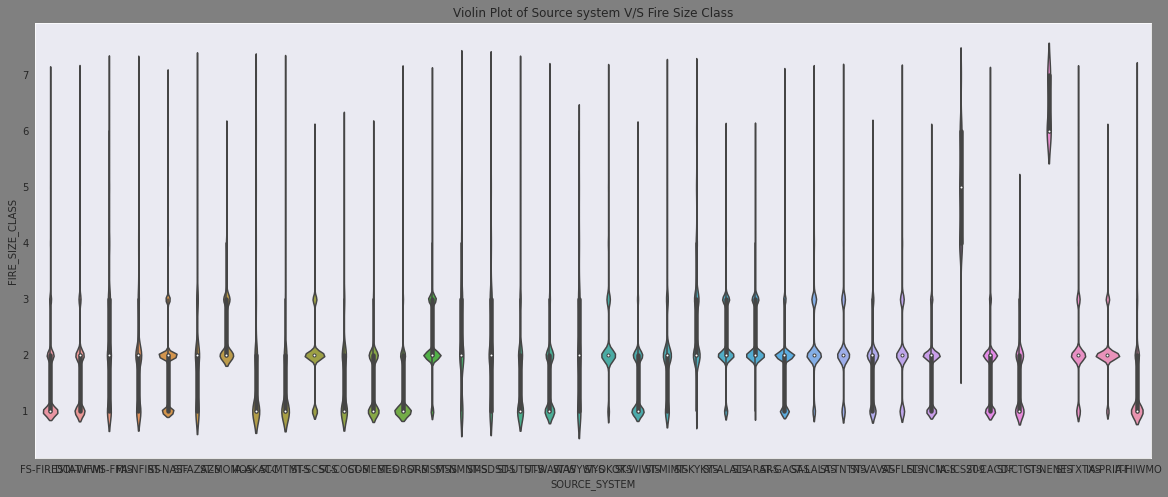

In [ ]:
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.violinplot(y="FIRE_SIZE_CLASS", x="SOURCE_SYSTEM", data=df, size=30)
plt.title('Violin Plot of Source system V/S Fire Size Class')
plt.show()

Observations: even though the Y-Axis values are overlapping, we can observe that the Median value of most Source systems is at Fire size class= 2 (This is also due to the data imbalance). But the interquartile range varies in each plot i.e. for each source system.
A lot of Plots have their Mdeian and Maximum width at fire size class = 1 (Eg. 1st and the last plot)
Even though these is a very few data available for fire size class 6 and 7, 4th plot from the end has all it's values lying between class 6 and 7. Therefore it is an important feature for analysis.


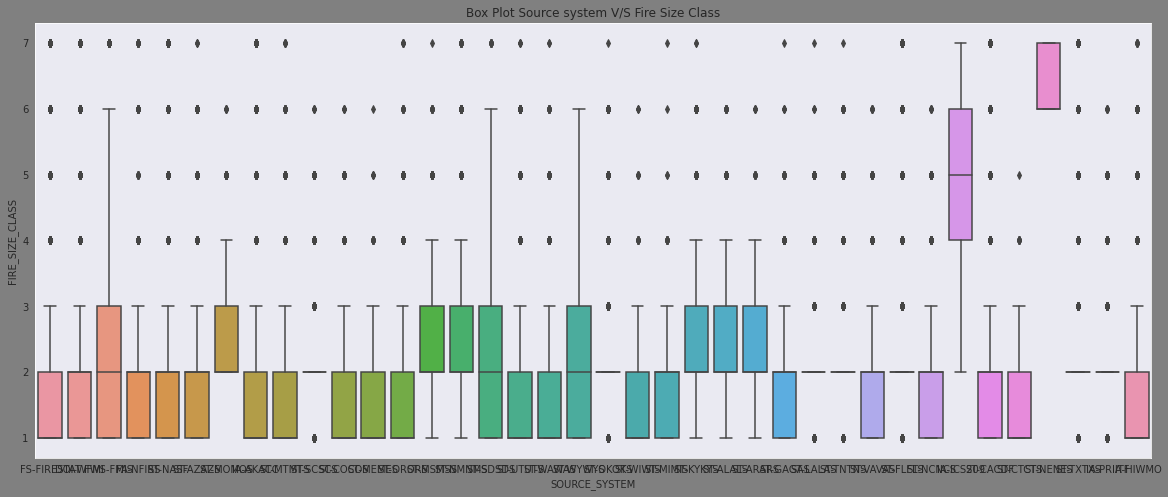

In [ ]:
#Box Plot
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.boxplot(x='SOURCE_SYSTEM',y='FIRE_SIZE_CLASS', data=df)
plt.title('Box Plot Source system V/S Fire Size Class')
plt.show()

Observations: For a more clear visualization, box plots are also drawn showing the source systems for each forest fire class. All observations of Violin plot apply here too.
Maximum and Minimum Quantile Ranges cover all the fire size classes but for most of them 25-75% of the values lie between class 1 and 2. 
This is clearly due to the imbalance of data. 
It has to be considered while doing classification by assigning weightage to each fire class.


In [13]:
#Encoding it using label encoder for putting it as an input feature to the model
df['SOURCE_SYSTEM']= label_encoder.fit_transform(df['SOURCE_SYSTEM']) 
df['SOURCE_SYSTEM'].astype('int64')

0           2
1           2
2           2
3           2
4           2
           ..
1880460    11
1880461    11
1880462    11
1880463    11
1880464    11
Name: SOURCE_SYSTEM, Length: 1880465, dtype: int64

In [ ]:
#Feature 6: NWCG_REPORTING_AGENCY
print('Unique values for Column NWCG_REPORTING_AGENCY are: ', df.NWCG_REPORTING_AGENCY.unique())
print('Length of Unique values for Column NWCG_REPORTING_AGENCY are: ', len(df.NWCG_REPORTING_AGENCY.unique()))
#Check for null values
bool_series = pd.isnull(df['NWCG_REPORTING_AGENCY'])
print('Number of null entries for Column NWCG_REPORTING_AGENCY are: ', len(df[bool_series]))

Unique values for Column NWCG_REPORTING_AGENCY are:  ['FS' 'BIA' 'TRIBE' 'BLM' 'NPS' 'BOR' 'FWS' 'ST/C&L' 'DOD' 'IA' 'DOE']
Length of Unique values for Column NWCG_REPORTING_AGENCY are:  11
Number of null entries for Column NWCG_REPORTING_AGENCY are:  0


In [14]:
#Converting it into numerical form 
df['NWCG_REPORTING_AGENCY']= label_encoder.fit_transform(df['NWCG_REPORTING_AGENCY']) 
df['NWCG_REPORTING_AGENCY'].astype('int64')

0          5
1          5
2          5
3          5
4          5
          ..
1880460    9
1880461    9
1880462    9
1880463    9
1880464    9
Name: NWCG_REPORTING_AGENCY, Length: 1880465, dtype: int64

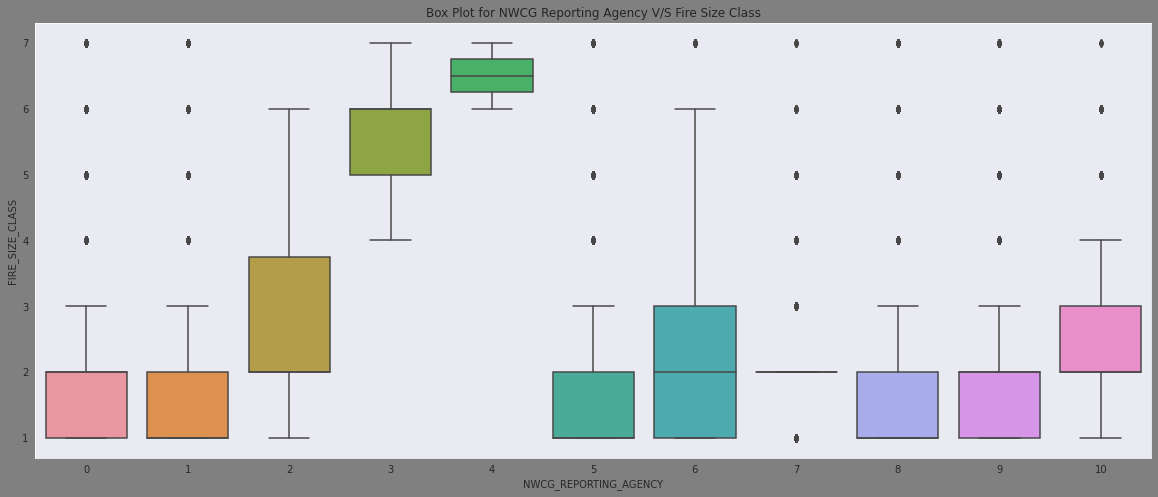

In [ ]:

plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.boxplot(x='NWCG_REPORTING_AGENCY',y='FIRE_SIZE_CLASS', data=df)
plt.title('Box Plot for NWCG Reporting Agency V/S Fire Size Class')
plt.show()

Observations: In most of the Box Plots, the median line is overlapping with the 25th/75th percentile lines. Most agencies have been reporting fires of size lying in class 1,2,3. 
But Agency 3 has 25-75% reported incidents lying in fire size class 5,6 and agency 4 between class 6 and 7.


In [ ]:
#Feature 7:NWCG_REPORTING_UNIT_ID
print('Unique values for Column NWCG_REPORTING_UNIT_ID are: ', df.NWCG_REPORTING_UNIT_ID.unique())
print('Length of Unique values for Column NWCG_REPORTING_UNIT_ID are: ', len(df.NWCG_REPORTING_UNIT_ID.unique()))
#Check for null values
bool_series = pd.isnull(df['NWCG_REPORTING_UNIT_ID'])
print('Number of null entries for Column NWCG_REPORTING_UNIT_ID are: ', len(df[bool_series]))

Unique values for Column NWCG_REPORTING_UNIT_ID are:  ['USCAPNF' 'USCAENF' 'USCASHF' ... 'USPRPRS' 'USWYPLX' 'USHINPS']
Length of Unique values for Column NWCG_REPORTING_UNIT_ID are:  1640
Number of null entries for Column NWCG_REPORTING_UNIT_ID are:  0


This feature is the Active NWCG Unit Identifier for the unit preparing the fire report. It does not give any information about the fire but tells about the unit that is preparing the fire report, therefore it won't be beneficial in predicting the fire size.



In [15]:
del df['NWCG_REPORTING_UNIT_ID']
df.shape

(1880465, 35)

In [ ]:
#Feature 8: NWCG_REPORTING_UNIT_NAME
print('Unique values for Column NWCG_REPORTING_UNIT_NAME are: ', df.NWCG_REPORTING_UNIT_NAME.unique())
print('Length of Unique values for Column NWCG_REPORTING_UNIT_NAME are: ', len(df.NWCG_REPORTING_UNIT_NAME.unique()))
#Check for null values
bool_series = pd.isnull(df['NWCG_REPORTING_UNIT_NAME'])
print('Number of null entries for Column NWCG_REPORTING_UNIT_NAME are: ', len(df[bool_series]))

Unique values for Column NWCG_REPORTING_UNIT_NAME are:  ['Plumas National Forest' 'Eldorado National Forest'
 'Shasta-Trinity National Forest' ... 'Puerto Rico Fire Service'
 'Platte County' 'National Parks in Hawaii']
Length of Unique values for Column NWCG_REPORTING_UNIT_NAME are:  1635
Number of null entries for Column NWCG_REPORTING_UNIT_NAME are:  0


NWCG_REPORTING_UNIT_NAME AND NWCG_REPORTING_UNIT_ID are two different representations of same feature, therefore it won't provide any value to our model too. So removing it:


In [16]:
#Removing NWCG_REPORTING_UNIT_NAME from our final dataset
del df['NWCG_REPORTING_UNIT_NAME']
df.shape

(1880465, 34)

In [ ]:
#Feature 9: SOURCE_REPORTING_UNIT
print('Unique values for Column SOURCE_REPORTING_UNIT are: ', df.SOURCE_REPORTING_UNIT.unique())
print('Length of Unique values for Column SOURCE_REPORTING_UNIT are: ', len(df.SOURCE_REPORTING_UNIT.unique()))
#Check for null values
bool_series = pd.isnull(df['SOURCE_REPORTING_UNIT'])
print('Number of null entries for Column SOURCE_REPORTING_UNIT are: ', len(df[bool_series]))

Unique values for Column SOURCE_REPORTING_UNIT are:  ['0511' '0503' '0514' ... 'WYPLX' 'COH-HFD' 'HINPS']
Length of Unique values for Column SOURCE_REPORTING_UNIT are:  4992
Number of null entries for Column SOURCE_REPORTING_UNIT are:  0


It is again a Code for the agency unit preparing the fire report, based on code/name in the source dataset just as NWCG_REPORTING_UNIT_ID. Therefore if does not provide any information about the fire itself. Just an identification code used for reporting purpose.

In [17]:
#Removing SOURCE_REPORTING_UNIT from our final dataset
del df['SOURCE_REPORTING_UNIT']
df.shape

(1880465, 33)

In [ ]:
#Feature 10: SOURCE_REPORTING_UNIT_NAME
print('Unique values for Column SOURCE_REPORTING_UNIT_NAME are: ', df.SOURCE_REPORTING_UNIT_NAME.unique())
print('Length of Unique values for Column SOURCE_REPORTING_UNIT_NAME are: ', len(df.SOURCE_REPORTING_UNIT_NAME.unique()))
#Check for null values
bool_series = pd.isnull(df['SOURCE_REPORTING_UNIT_NAME'])
print('Number of null entries for Column SOURCE_REPORTING_UNIT_NAME are: ', len(df[bool_series]))

Unique values for Column SOURCE_REPORTING_UNIT_NAME are:  ['Plumas National Forest' 'Eldorado National Forest'
 'Shasta-Trinity National Forest' ...
 'County of Hawaii - Hawaii Fire Department' 'Honolulu Fire Dept'
 'National Parks in Hawaii']
Length of Unique values for Column SOURCE_REPORTING_UNIT_NAME are:  4441
Number of null entries for Column SOURCE_REPORTING_UNIT_NAME are:  0


This feature is again just a different representation of SOURCE_REPORTING_UNIT feature. Therefore removing it too.

In [18]:
del df['SOURCE_REPORTING_UNIT_NAME']
df.shape

(1880465, 32)

In [ ]:
#Feature 11: LOCAL_FIRE_REPORT_ID
print('Unique values for Column LOCAL_FIRE_REPORT_ID are: ', df.LOCAL_FIRE_REPORT_ID.unique())
print('Length of Unique values for Column LOCAL_FIRE_REPORT_ID are: ', len(df.LOCAL_FIRE_REPORT_ID.unique()))
#Check for null values
bool_series = pd.isnull(df['LOCAL_FIRE_REPORT_ID'])
print('Number of null entries for Column LOCAL_FIRE_REPORT_ID are: ', len(df[bool_series]))
bool_series2 = pd.notnull(df['LOCAL_FIRE_REPORT_ID'])
print('Number of non null entries for Column LOCAL_FIRE_REPORT_ID are: ', len(df[bool_series2]))

#This feature is also just a unique identifier for each fire and does not add much value to our analysis
#Moreover most of the values are null therefore not using it

Unique values for Column LOCAL_FIRE_REPORT_ID are:  ['1' '13' '27' ... '574245' '570462' '535436']
Length of Unique values for Column LOCAL_FIRE_REPORT_ID are:  13509
Number of null entries for Column LOCAL_FIRE_REPORT_ID are:  1459286
Number of non null entries for Column LOCAL_FIRE_REPORT_ID are:  421179


OBSERVATION:  LOCAL_FIRE_REPORT_ID is just a number or code that uniquely identifies an incident report for a particular reporting unit and a particular calendar year.
Therefore it won't be useful in classfying our fire size classes.


In [19]:
#removing this feature
del df['LOCAL_FIRE_REPORT_ID']
df.shape

(1880465, 31)

In [ ]:
#Feature 12: LOCAL_INCIDENT_ID
print('Unique values for Column LOCAL_INCIDENT_ID are: ', df.LOCAL_INCIDENT_ID.unique())
print('Length of Unique values for Column LOCAL_INCIDENT_ID are: ', len(df.LOCAL_INCIDENT_ID.unique()))
#Check for null values
bool_series = pd.isnull(df['LOCAL_INCIDENT_ID'])
print('Number of null entries for Column LOCAL_INCIDENT_ID are: ', len(df[bool_series]))
bool_series2 = pd.notnull(df['LOCAL_INCIDENT_ID'])
print('Number of non null entries for Column LOCAL_INCIDENT_ID are: ', len(df[bool_series2]))

Unique values for Column LOCAL_INCIDENT_ID are:  ['PNF-47' '13' '021' ... '005748' '009371' '000366']
Length of Unique values for Column LOCAL_INCIDENT_ID are:  565915
Number of null entries for Column LOCAL_INCIDENT_ID are:  820821
Number of non null entries for Column LOCAL_INCIDENT_ID are:  1059644


Observation: it is just a number or code that uniquely identifies an incident for a particular local fire management organization within a particular calendar year.
Therefore used just for identification purpose and not related to the fire.

In [20]:
#Removing the feature
del df['LOCAL_INCIDENT_ID']
df.shape

(1880465, 30)

In [ ]:
#Feature 13: FIRE_CODE
print('Unique values for Column FIRE_CODE are: ', df.FIRE_CODE.unique())
print('Length of Unique values for Column FIRE_CODE are: ', len(df.FIRE_CODE.unique()))
#Check for null values
bool_series = pd.isnull(df['FIRE_CODE'])
print('Number of null entries for Column FIRE_CODE are: ', len(df[bool_series]))
bool_series2 = pd.notnull(df['FIRE_CODE'])
print('Number of non null entries for Column FIRE_CODE are: ', len(df[bool_series2]))

Unique values for Column FIRE_CODE are:  ['BJ8K' 'AAC0' 'A32W' ... 'J5AS' 'J3NM' 'J48B']
Length of Unique values for Column FIRE_CODE are:  172447
Number of null entries for Column FIRE_CODE are:  1555636
Number of non null entries for Column FIRE_CODE are:  324829


Observation: It is the code used within the interagency wildland fire community to track and compile cost information for emergency fire suppression. 
Number of null entries here are much more than the entries present. Therefore removing it as a feature.


In [21]:
#Removing the feature
del df['FIRE_CODE']
df.shape

(1880465, 29)

In [ ]:
#Feature 14: FIRE_NAME
print('Unique values for Column FIRE_NAME are: ', df.FIRE_NAME.unique())
print('Length of Unique values for Column FIRE_NAME are: ', len(df.FIRE_NAME.unique()))
#Check for null values
bool_series = pd.isnull(df['FIRE_NAME'])
print('Number of null entries for Column FIRE_NAME are: ', len(df[bool_series]))
bool_series2 = pd.notnull(df['FIRE_NAME'])
print('Number of non null entries for Column FIRE_NAME are: ', len(df[bool_series2]))

Unique values for Column FIRE_NAME are:  ['FOUNTAIN' 'PIGEON' 'SLACK' ... '1-64' 'ODESSA 2'
 'BARKER BL  BIG_BEAR_LAKE_']
Length of Unique values for Column FIRE_NAME are:  493634
Number of null entries for Column FIRE_NAME are:  957189
Number of non null entries for Column FIRE_NAME are:  923276


Observation: Here again we have 50% of values present and 50% not present. 
It is the name of the incident, from the fire report (primary) or ICS-209 report. It does not show any connection with the fire size class.

In [22]:
#Removing the feature
del df['FIRE_NAME']
df.shape

(1880465, 28)

In [ ]:
#Feature 15: ICS_209_INCIDENT_NUMBER
print('Unique values for Column ICS_209_INCIDENT_NUMBER are: ', df.ICS_209_INCIDENT_NUMBER.unique())
print('Length of Unique values for Column ICS_209_INCIDENT_NUMBER are: ', len(df.ICS_209_INCIDENT_NUMBER.unique()))
#Check for null values
bool_series = pd.isnull(df['ICS_209_INCIDENT_NUMBER'])
print('Number of null entries for Column ICS_209_INCIDENT_NUMBER are: ', len(df[bool_series]))
bool_series2 = pd.notnull(df['ICS_209_INCIDENT_NUMBER'])
print('Number of non null entries for Column ICS_209_INCIDENT_NUMBER are: ', len(df[bool_series2]), '\n')

#Feature 16: ICS_209_NAME
print('Unique values for Column ICS_209_NAME are: ', df.ICS_209_NAME.unique())
print('Length of Unique values for Column ICS_209_NAME are: ', len(df.ICS_209_NAME.unique()))
#Check for null values
bool_series = pd.isnull(df['ICS_209_NAME'])
print('Number of null entries for Column are: ', len(df[bool_series]))
bool_series2 = pd.notnull(df['ICS_209_NAME'])
print('Number of non null entries for Column ICS_209_NAME are: ', len(df[bool_series2]))

Unique values for Column ICS_209_INCIDENT_NUMBER are:  [None 'CA-ENF-017646' 'CA-ENF-18044' ... '010969' 'CA-LMU-2725' '474967']
Length of Unique values for Column ICS_209_INCIDENT_NUMBER are:  22738
Number of null entries for Column ICS_209_INCIDENT_NUMBER are:  1854748
Number of non null entries for Column ICS_209_INCIDENT_NUMBER are:  25717 

Unique values for Column ICS_209_NAME are:  [None 'POWER' 'FREDS' ... 'FORTY NINE' 'Swedes' 'Popcorn']
Length of Unique values for Column ICS_209_NAME are:  19574
Number of null entries for Column are:  1854748
Number of non null entries for Column ICS_209_NAME are:  25717


Observation: INCIDENT_NUMBER and INCIDENT_NAME are again just identifiers and number of null features are much greater than number of non null features. Therefore these two can't be used as features too.

In [23]:
#Removing the feature
del df['ICS_209_INCIDENT_NUMBER']
del df['ICS_209_NAME']
df.shape

(1880465, 26)

In [ ]:
#Feature 17: MTBS_ID
print('Unique values for Column MTBS_ID are: ', df.MTBS_ID.unique())
print('Length of Unique values for Column MTBS_ID are: ', len(df.MTBS_ID.unique()))
#Check for null values
bool_series = pd.isnull(df['MTBS_ID'])
print('Number of null entries for Column MTBS_ID are: ', len(df[bool_series]))
bool_series2 = pd.notnull(df['MTBS_ID'])
print('Number of non null entries for Column MTBS_ID are: ', len(df[bool_series2]), '\n')

#Feature 18: MTBS_FIRE_NAME
print('Unique values for Column MTBS_FIRE_NAME are: ', df.MTBS_FIRE_NAME.unique())
print('Length of Unique values for Column MTBS_FIRE_NAME are: ', len(df.MTBS_FIRE_NAME.unique()))
#Check for null values
bool_series = pd.isnull(df['MTBS_FIRE_NAME'])
print('Number of null entries for Column MTBS_FIRE_NAME are: ', len(df[bool_series]))
bool_series2 = pd.notnull(df['MTBS_FIRE_NAME'])
print('Number of non null entries for Column MTBS_FIRE_NAME are: ', len(df[bool_series2]))

Unique values for Column MTBS_ID are:  [None 'CA3850212028020041006' 'CA3878712031820041013' ...
 'CA3639412158320150919' 'CA3790512187420130908' 'CA3944512141720130816']
Length of Unique values for Column MTBS_ID are:  10482
Number of null entries for Column MTBS_ID are:  1869462
Number of non null entries for Column MTBS_ID are:  11003 

Unique values for Column MTBS_FIRE_NAME are:  [None 'POWER' 'FREDS' ... 'CORRINE' 'TASSAJARA' 'SWEDES']
Length of Unique values for Column MTBS_FIRE_NAME are:  8134
Number of null entries for Column MTBS_FIRE_NAME are:  1869462
Number of non null entries for Column MTBS_FIRE_NAME are:  11003


Observations: These two are identifiers again and almost all values null, therefore cannot be used.

In [24]:
#Removing the feature
del df['MTBS_FIRE_NAME']
del df['MTBS_ID']
df.shape

(1880465, 24)

In [ ]:
#Feature 19: COMPLEX_NAME
print('Unique values for Column COMPLEX_NAME are: ', df.COMPLEX_NAME.unique())
print('Length of Unique values for Column COMPLEX_NAME are: ', len(df.COMPLEX_NAME.unique()))
#Check for null values
bool_series = pd.isnull(df['COMPLEX_NAME'])
print('Number of null entries for Column COMPLEX_NAME are: ', len(df[bool_series]))
bool_series2 = pd.notnull(df['COMPLEX_NAME'])
print('Number of non null entries for Column COMPLEX_NAME are: ', len(df[bool_series2]))

Unique values for Column COMPLEX_NAME are:  [None 'THREE FIRE COMPLEX' 'GOLDILOCKS COMPLEX' ... 'HENDERSON COMPLEX'
 'LODGE COMPLEX' 'JAMUL COMPLEX']
Length of Unique values for Column COMPLEX_NAME are:  1417
Number of null entries for Column COMPLEX_NAME are:  1875282
Number of non null entries for Column COMPLEX_NAME are:  5183


Number of null entries is aprox 360 times more than number of entries present, therefore we should remove this feature too.

In [25]:
del df['COMPLEX_NAME']
df.shape

(1880465, 23)

In [ ]:
#Feature 20: FIRE_YEAR
print('Unique values for Column FIRE_YEAR are: ', df.FIRE_YEAR.unique())
print('Length of Unique values for Column FIRE_YEAR are: ', len(df.FIRE_YEAR.unique()))
#Check for null values
bool_series = pd.isnull(df['FIRE_YEAR'])
print('Number of null entries for Column FIRE_YEAR are: ', len(df[bool_series]))

Unique values for Column FIRE_YEAR are:  [2005 2004 2006 2008 2002 2007 2009 2001 2003 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2010 2011 2012 2013 2014 2015]
Length of Unique values for Column FIRE_YEAR are:  24
Number of null entries for Column FIRE_YEAR are:  0


This feature is already in integer form and has 0 null values, therefore no changes are required and can be analysed straight away


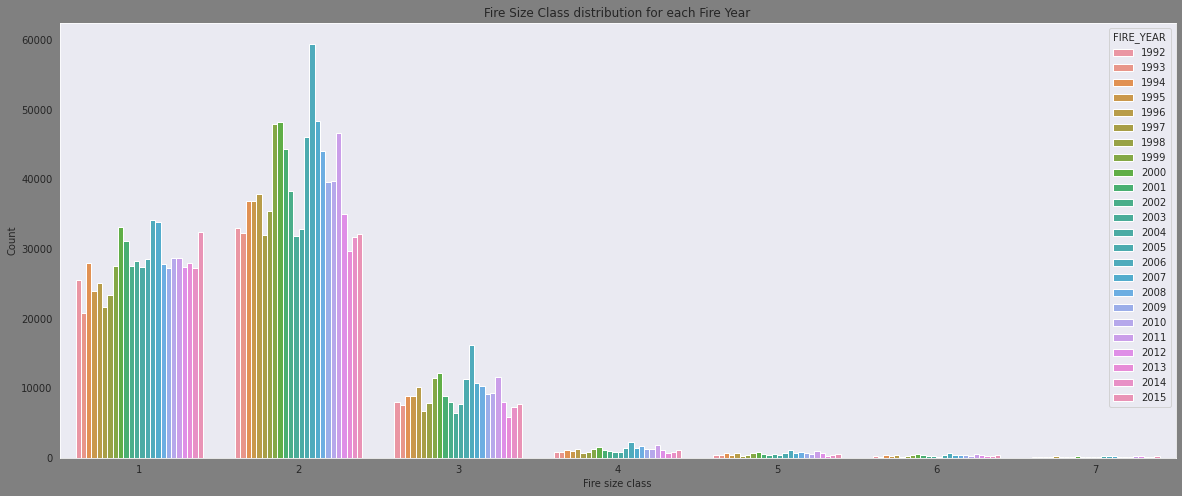

In [ ]:
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='FIRE_SIZE_CLASS', hue = "FIRE_YEAR", data = df) 
plt.xlabel('Fire size class')
plt.ylabel('Count')
plt.title('Fire Size Class distribution for each Fire Year')
plt.show()


Observations: Even though we have maximum data for forest fires lying in class 2, we can see that for all classes (1-7), Maximum forest fires are observed between years 2004-2007.
We are interchanging the x-axis and the hue values for viewing it trhough a different perspective.

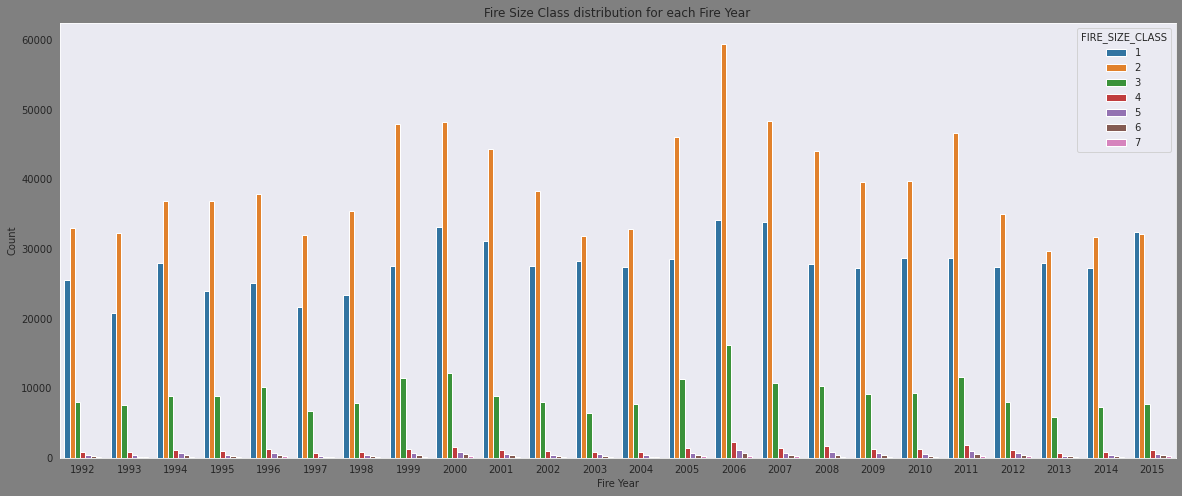

In [ ]:
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='FIRE_YEAR', hue = "FIRE_SIZE_CLASS", data = df) 
plt.xlabel('Fire Year')
plt.ylabel('Count')
plt.title('Fire Size Class distribution for each Fire Year')
plt.show()


Observation: Year 2006 has seen maximum forest fires not just class 2 fires but also Class 1 and Class 3 are visibly higher than any other year. 
More recent years i.e. 2014, 2015 show similar numbers which are not as high as 2006.
Since for every year, most of the count values are of fires lying in class 1,2 and 3, for analysing fires lying in other classes, We can analyse the fires with dataset not having fires of classes 1, 2 and 3 

In [31]:
#Creating a mask to filter out fires lying in class 1 and 2
df_filtered = (df["FIRE_SIZE_CLASS"] != 1) & (df['FIRE_SIZE_CLASS'] !=2) & (df['FIRE_SIZE_CLASS'] !=3)

In [32]:
#Filtering as per the boolean values obtained from the mask
dff = df[df_filtered]

In [ ]:
dff.shape

(54093, 23)

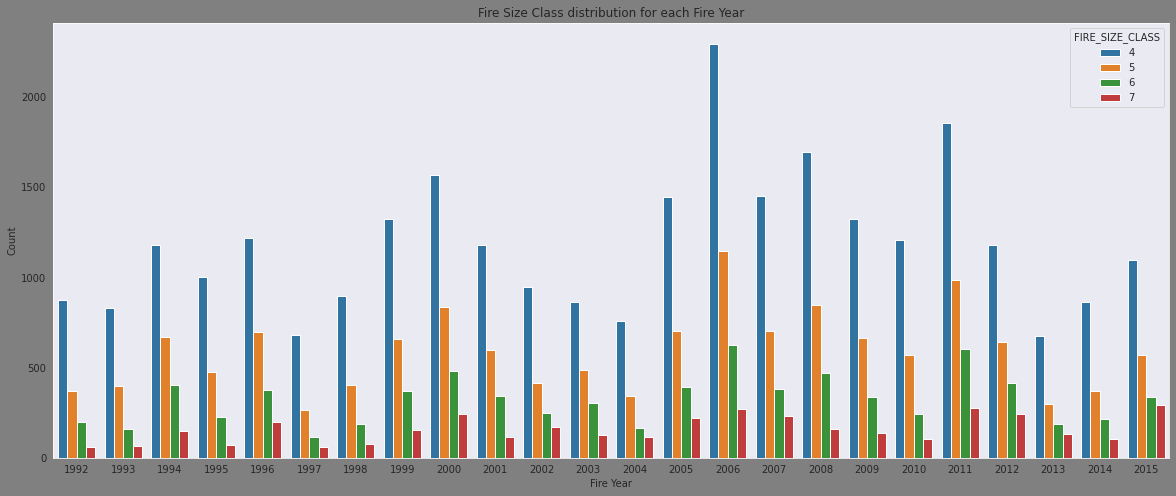

In [ ]:
#Drawing the above plot again: this time with 2 fire size classes missing (data changed from df to dff)
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='FIRE_YEAR', hue = "FIRE_SIZE_CLASS", data = dff) 
plt.xlabel('Fire Year')
plt.ylabel('Count')
plt.title('Fire Size Class distribution for each Fire Year')
plt.show()

Observation: This is a graph of filtered data such that the data contains only fires of classes 4,5,6,7.
After analysing the filtered data, we observe that in 2006, even the fires of bigger sizes are much more than other years. 
Fires of class 7 (biggest size) are the largest in years 2006, 2007, 2011, 2012 and 2015.

In [ ]:
#Feature 21: DISCOVERY_DATE
print('Unique values for Column DISCOVERY_DATE are: ', df.DISCOVERY_DATE.unique())
print('Length of Unique values for Column DISCOVERY_DATE are: ', len(df.DISCOVERY_DATE.unique()))
#Check for null values
bool_series = pd.isnull(df['DISCOVERY_DATE'])
print('Number of null entries for Column DISCOVERY_DATE are: ', len(df[bool_series]))

Unique values for Column DISCOVERY_DATE are:  [2453403.5 2453137.5 2453156.5 ... 2457030.5 2457381.5 2457385.5]
Length of Unique values for Column DISCOVERY_DATE are:  8766
Number of null entries for Column DISCOVERY_DATE are:  0


Discovery date is present in julian format, it can be converted into YYYY-MM-DD format for better understanding but we already have Discovery Year, Discovery Day of Year from which we can get the month of forest fire and after that we have discovery time which can be used to find out at which interval of the day did the fire occur, therefor this feature: DISCOVERY_DATE would not add any value to our dataset and can be discarded.

In [26]:
del df['DISCOVERY_DATE']
df.shape

(1880465, 22)

In [ ]:
#Feature 22: DISCOVERY_DOY
#FROM THIS VALUE, WE CAN EASILY FETCH THE MONTH INSTEAD OF USING DISCOVERY DATE ALL TOGETHER: AND THEN WE CAN DISCARD THIS FEATURE TOO
print('Unique values for Column DISCOVERY_DOY are: ', df.DISCOVERY_DOY.unique())
print('Length of Unique values for Column DISCOVERY_DOY are: ', len(df.DISCOVERY_DOY.unique()))
#Check for null values
bool_series = pd.isnull(df['DISCOVERY_DOY'])
print('Number of null entries for Column DISCOVERY_DOY are: ', len(df[bool_series]))

Unique values for Column DISCOVERY_DOY are:  [ 33 133 152 180 182 183  67  74 184 247 272 277 280 287 325 156 171 173
 177 202  78 218 132  36 243 285  64  70  27  37  43 106 129  95 157 165
  47  61 148 137 147  97 170 176  65 175 167 150 172 179 117 114 185 186
 122 149 136 178 104 169 191 190 138 188   2 195 126 189 162 115 199 196
 198 197 164  57 110 168 181 200 310 194 151 203  41  45 140 205 201 204
 207 174 192 208 209 143 100 111 123 153 193  87 210 154 163  93  96 103
 146 107  24  25  71 108 105 112 142 206 160 211 159 166 187 212  69  34
 214 155  40  42 158 124 127  76  94 161 217  68 215 219  75  98  99  23
 101  63 223 220 213  38  50 125 216 222 221 225  39 226 224 113  81  84
  92 145 228 229 128 134  22  30  32  12 231 139 118 233  48 135  58 232
 234 236  49 235  72  77  79  80  88 239 237  26  46 238 241  89  44 102
  60  15 242  66 240 227 244  55 119 252  51 248 246  90 250 251 109 130
 245 230  85 249 253 254 255 256 261 259 264 131 144 267 268 266 269 258
 262  

Instead of keep the days, we can easily fetch the month value from it and can discard this feature then. 

In [27]:
#Make avg_temp as a list
discovery_month = [];
for i in range(len(df)):
  key = df.iloc[i]['DISCOVERY_DOY']
  if( 1 <= key <= 31 ):
    discovery_month.append(1)
  elif ( 32 <= key <= 60 ):
    discovery_month.append(2)
  elif ( 61 <= key <= 91 ):
    discovery_month.append(3)
  elif ( 92 <= key <= 121 ):
    discovery_month.append(4)
  elif ( 122 <= key <= 152 ):
    discovery_month.append(5)
  elif ( 153 <= key <= 182 ):
    discovery_month.append(6)
  elif ( 183 <= key <= 213 ):
    discovery_month.append(7)
  elif ( 214 <= key <= 244 ):
    discovery_month.append(8)
  elif ( 245 <= key <= 274 ):
    discovery_month.append(9)
  elif ( 275 <= key <= 305 ):
    discovery_month.append(10)
  elif ( 306 <= key <= 335 ):
    discovery_month.append(11)
  elif ( 336 <= key <= 366 ):
    discovery_month.append(12)

In [ ]:
len(discovery_month)

1880465

In [28]:
df['DISCOVERY_MONTH'] = discovery_month
df['DISCOVERY_MONTH'].astype('int64')

0           2
1           5
2           5
3           6
4           6
           ..
1880460     9
1880461    10
1880462     5
1880463    10
1880464     3
Name: DISCOVERY_MONTH, Length: 1880465, dtype: int64

In [33]:
#Again filtering out the dataset for analyzing the rows which do not fall in fire size class 1 and 2
dff = df[df_filtered]

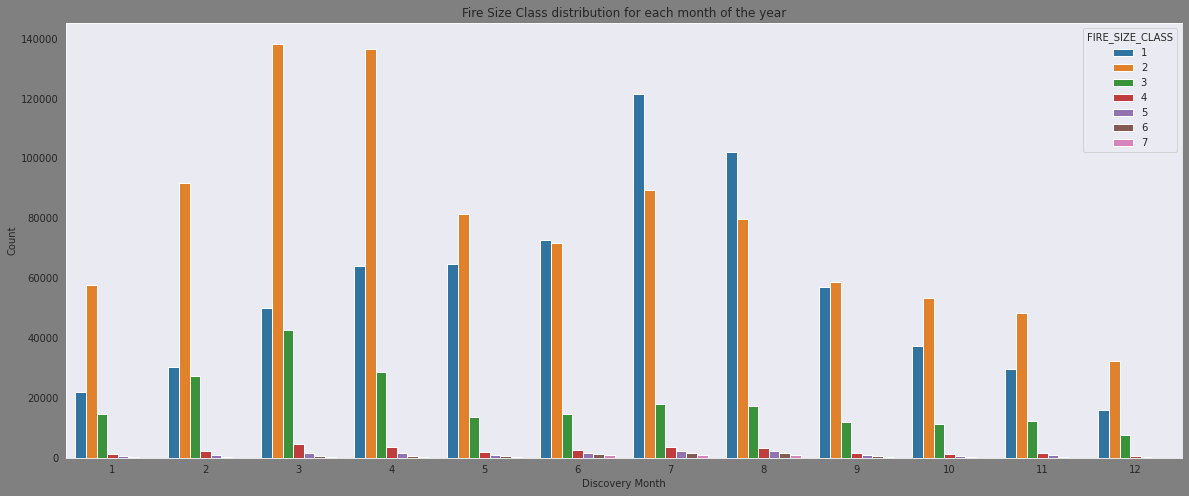

In [34]:
#Graphical analysis of discovery month feature
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='DISCOVERY_MONTH', hue = "FIRE_SIZE_CLASS", data = df) 
plt.xlabel('Discovery Month')
plt.ylabel('Count')
plt.title('Fire Size Class distribution for each month of the year')
plt.show()

Observations: This feature provides some useful insights on the variation of fire size classes based on the month of year as we can see in the months of January-April(1-4) fires of area class 2 have occured much more than any other class. 
Then in month of May(5), fires of class 2 have reduced abruptly and we can see a slight increase in bigger fire classes (class 5 and 6 values appeared).
During months June-August (6-8), we can see forest fires of class 7 present that is huge area of forest fires. 
After that in months September-December(9-12), the forest fires have reduced.

Therefore it is an extremely important feature to have.

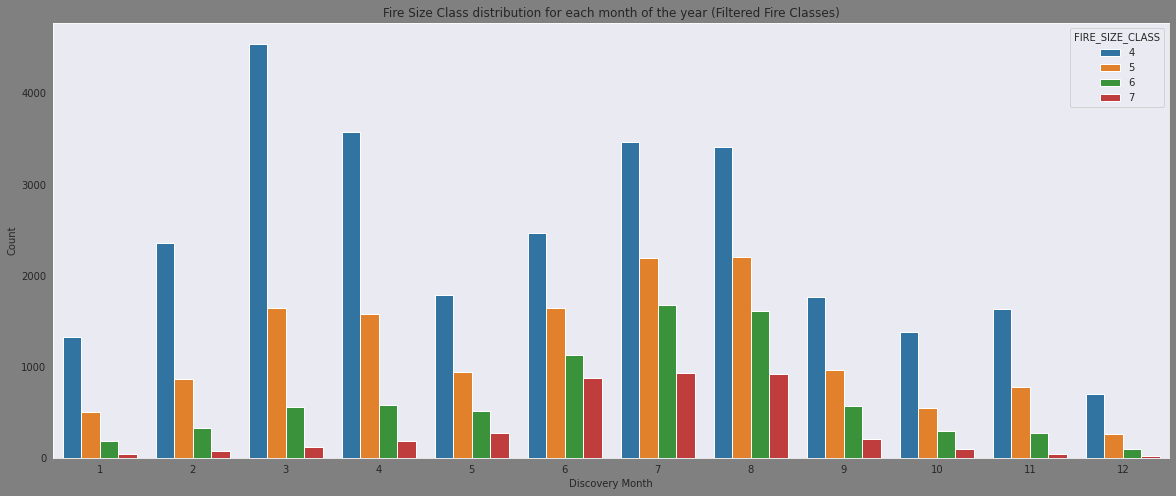

In [35]:
#Again analysing data where fire size classes are greater than 3: So using dataset dff
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='DISCOVERY_MONTH', hue = "FIRE_SIZE_CLASS", data = dff) 
plt.xlabel('Discovery Month')
plt.ylabel('Count')
plt.title('Fire Size Class distribution for each month of the year (Filtered Fire Classes)')
plt.show()

Observations:This graph only shows the fires of classes 4,5,6 and 7. while in the month of March, the fires of size class 4 are the maximum but In the months of July and August (7 and 8) Fires from all classes i.e. all sizes of fires (Refering the above graph and this one) occur the most. 

In [ ]:
del df['DISCOVERY_DATE']
df.shape

In [ ]:
#Feature 23: DISCOVERY_TIME
print('Unique values for Column DISCOVERY_TIME are: ', df.DISCOVERY_TIME.unique())
print('Length of Unique values for Column DISCOVERY_TIME are: ', len(df.DISCOVERY_TIME.unique()))
#Check for null values
bool_series = pd.isnull(df['DISCOVERY_TIME'])
print('Number of null entries for Column DISCOVERY_TIME are: ', len(df[bool_series]))

Unique values for Column DISCOVERY_TIME are:  ['1300' '0845' '1921' ... '0102' '0204' '0226']
Length of Unique values for Column DISCOVERY_TIME are:  1441
Number of null entries for Column DISCOVERY_TIME are:  882638


Instead of having unique values of forest fire time (minute wise), we can instead classify the time based on time intervals of the day which would be more useful in classification.

In [37]:
#Check if any forest fire has it's discovery time 0000 which can then be used for fires having null values for discovery times
print('Number of forest fires having discovery time to be 00:00: ', len(df[df['DISCOVERY_TIME'] == '0000']))

Number of forest fires having discovery time to be 00:00:  667


The time is present in 24 hour format, instead of using individual time values (minute wise), we can get the time interval of the day from it i.e. 
1. Early Morning (0-0600), 
2. Morning(0600-1200),
3. Noon(1200-1600), 
4. Evening(1600-2000), 
5. Night(2000-2400).

We also have a lot of null entries in the column, for null values, using the standard 0000 time which is generally used when time of the day is not known

So converting it into iteger form:

* null values: 0
* Early Morning: 1
* Morning: 2
* Noon: 3
* Evening: 4
* Night: 5


In [38]:
#1st replacing null values with 0000
df['DISCOVERY_TIME'] = df['DISCOVERY_TIME'].replace([None],'0000')

In [39]:
#Verifying that there are no null values now
bool_series = pd.isnull(df['DISCOVERY_TIME'])
print('Number of null entries for Column DISCOVERY_TIME are: ', len(df[bool_series]))

Number of null entries for Column DISCOVERY_TIME are:  0


In [40]:
discovery_tod = [];
for i in range(len(df)):
  key = df.iloc[i]['DISCOVERY_TIME']
  if( key == '0000' ):
    discovery_tod.append(0)
  elif ( '0000' < key <= '0600' ):
    discovery_tod.append(1)
  elif ( '0600' < key <= '1200' ):
    discovery_tod.append(2)
  elif ( '1200' < key <= '1600' ):
    discovery_tod.append(3)
  elif ( '1600' < key <= '2000' ):
    discovery_tod.append(4)
  elif ( '2000' < key <= '2400' ):
    discovery_tod.append(5)

In [41]:
len(discovery_tod)

1880465

In [42]:
df['DISCOVERY_TOD'] = discovery_tod
df['DISCOVERY_TOD'].astype('int64')

0          3
1          2
2          4
3          3
4          3
          ..
1880460    4
1880461    1
1880462    5
1880463    5
1880464    5
Name: DISCOVERY_TOD, Length: 1880465, dtype: int64

In [43]:
#updating the filtered dataset
dff = df[df_filtered]

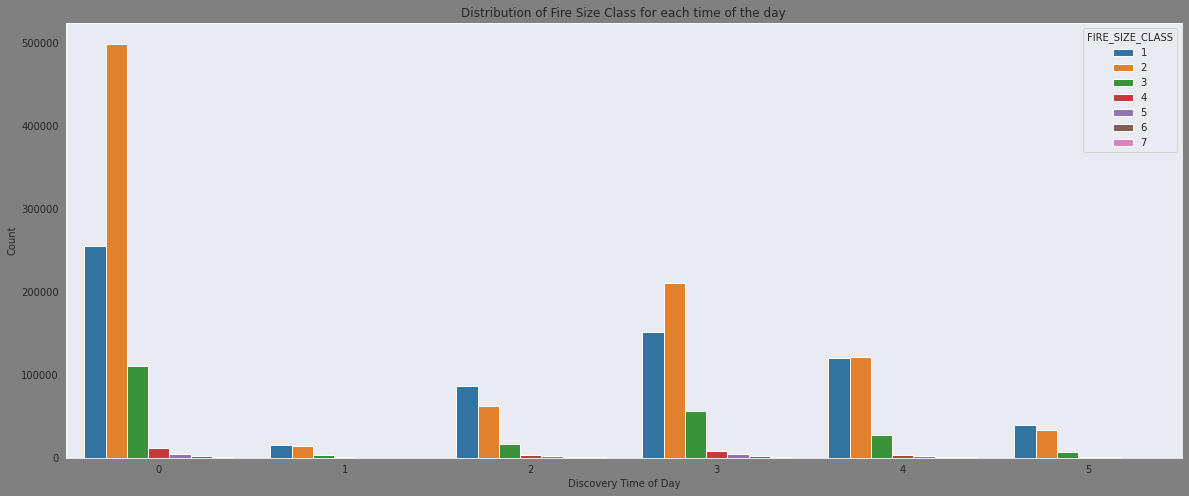

In [44]:
#Graphical analysis of discovery month feature
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='DISCOVERY_TOD', hue = "FIRE_SIZE_CLASS", data = df) 
plt.xlabel('Discovery Time of Day')
plt.ylabel('Count')
plt.title('Distribution of Fire Size Class for each time of the day')
plt.show()

Observation: Most of the fires are discovered in the early morning period i.e. between 0000-0600 (12 A.M - 6 A.M.)
Least number of fires occue after that, i.e. Morning hours (6 A.M. to 12 P.M.)


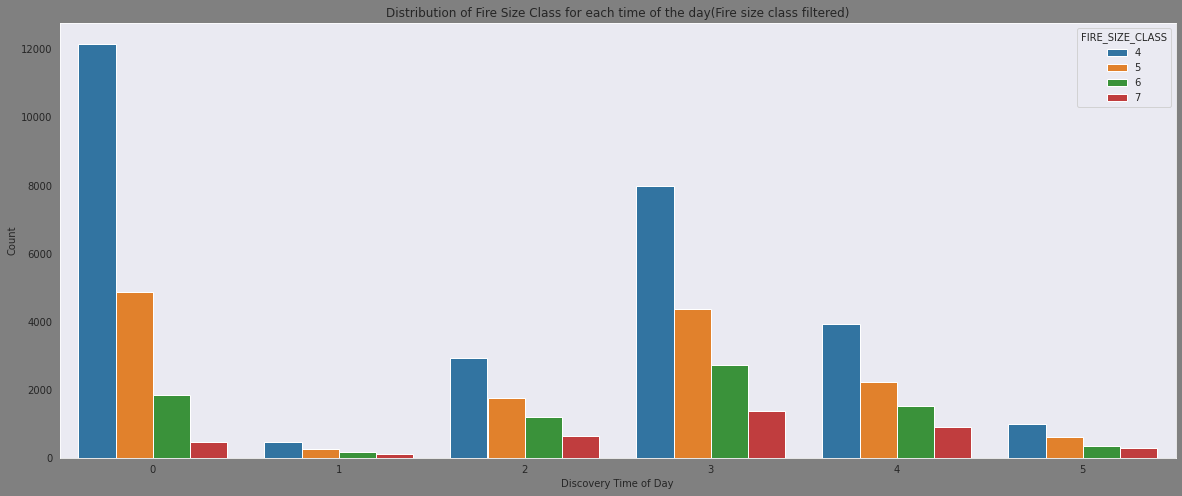

In [45]:
#Plotting for smaller fire classes
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='DISCOVERY_TOD', hue = "FIRE_SIZE_CLASS", data = dff) 
plt.xlabel('Discovery Time of Day')
plt.ylabel('Count')
plt.title('Distribution of Fire Size Class for each time of the day(Fire size class filtered)')
plt.show()

Observations: Even though the fires of size lying between class 1-4 have maximum number of occurances between the time period 12:00 A.M. - 06:00 A.M. 
But for bigger fire sizes (class 5-7), the time period in which maximum fires have occured in the past is 12:00 - 16:00 i.e. 12:00 P.M. - 04:00 P.M.

The time period for minimum fire incidents observed for all classes remain the same (Morning hours: 6 A.M - 12 P.M.).

In [46]:
#Removing the DISCOVERY_TIME feature now, as it is no more required
del df['DISCOVERY_TIME']
df.shape

(1880465, 23)

In [47]:
#Feature 24: STAT_CAUSE_CODE
print('Unique values for Column STAT_CAUSE_CODE are: ', df.STAT_CAUSE_CODE.unique())
print('Length of Unique values for Column STAT_CAUSE_CODE are: ', len(df.STAT_CAUSE_CODE.unique()))
#Check for null values
bool_series = pd.isnull(df['STAT_CAUSE_CODE'])
print('Number of null entries for Column STAT_CAUSE_CODE are: ', len(df[bool_series]))

Unique values for Column STAT_CAUSE_CODE are:  [ 9.  1.  5.  4.  2.  7.  8.  6.  3. 11. 12. 10. 13.]
Length of Unique values for Column STAT_CAUSE_CODE are:  13
Number of null entries for Column STAT_CAUSE_CODE are:  0


This feature can be used as it is as there are no null values and the data is already in integer form. it is the code for the (statistical) cause of the fire. Therefore theoretically it is very important, let's see it's importance graphically.



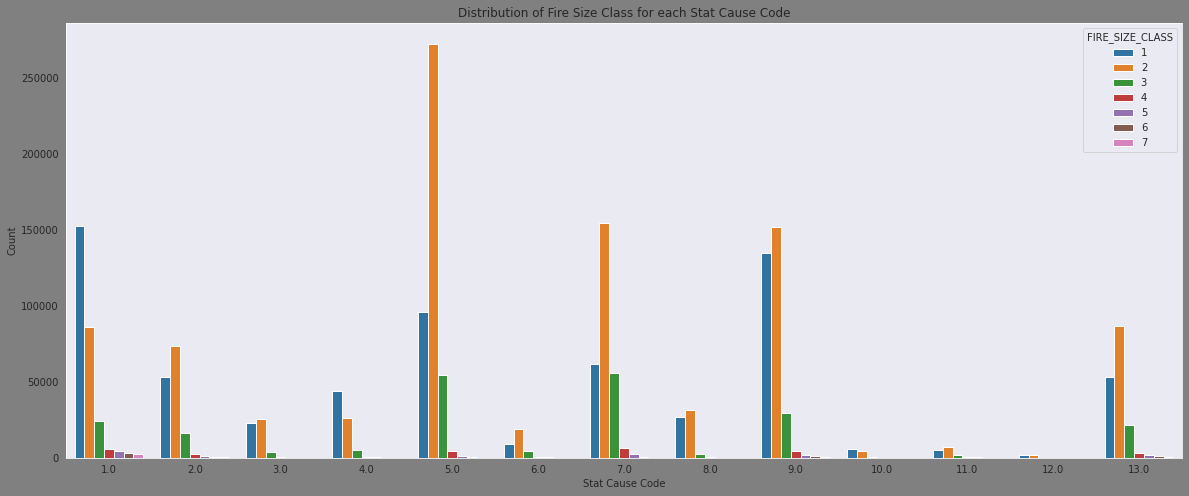

In [ ]:
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='STAT_CAUSE_CODE', hue = "FIRE_SIZE_CLASS", data = df) 
plt.xlabel('Stat Cause Code')
plt.ylabel('Count')
plt.title('Distribution of Fire Size Class for each Stat Cause Code')
plt.show()

Observations: When the fire cause code is 1: we have maximum fires of size 1.
Infact these is a probability of fires from all 7 size classes to be present in it, on looking at the STAT_CAUSE_DESC feature we realized that class 1 is actually 'Miscellaneous' therefore it makes sense.
For causes of class 10 (Powerline), very less fires are cause due to it as the count is very small and even when the fires are cause, the fires are only of class size 1 or 2 i.e. small fires. 
Similarly cause 12 (Fireworks) has the least number of instances and only in class 1 and 2.
For class 9 (Smoking) we can see fires of class 3,4,5 and 6 along with 1 and 2 i.e. smoking can cause huge fires and is a much more dangerous cause.

In [ ]:
#Feature 25: STAT_CAUSE_DESCR
print('Unique values for Column STAT_CAUSE_DESCR are: ', df.STAT_CAUSE_DESCR.unique())
print('Length of Unique values for Column STAT_CAUSE_DESCR are: ', len(df.STAT_CAUSE_DESCR.unique()))
#Check for null values
bool_series = pd.isnull(df['STAT_CAUSE_DESCR'])
print('Number of null entries for Column STAT_CAUSE_DESCR are: ', len(df[bool_series]))

Unique values for Column STAT_CAUSE_DESCR are:  ['Miscellaneous' 'Lightning' 'Debris Burning' 'Campfire' 'Equipment Use'
 'Arson' 'Children' 'Railroad' 'Smoking' 'Powerline' 'Structure'
 'Fireworks' 'Missing/Undefined']
Length of Unique values for Column STAT_CAUSE_DESCR are:  13
Number of null entries for Column STAT_CAUSE_DESCR are:  0


STAT_CAUSE_DESCR and STAT_CAUSE_CODE are different representations of same feature, even though STAT_CAUSE_DESCR is easy to understand in human terms but STAT_CAUSE_CODE is just numerical representation of it which is easier to understand for any ML model, therefore taking STAT_CAUSE_CODE as a feature and discarding the dsecription

In [48]:
del df['STAT_CAUSE_DESCR']
df.shape

(1880465, 22)

In [ ]:
#Feature 26: CONT_DATE
print('Unique values for Column CONT_DATE are: ', df.CONT_DATE.unique())
print('Length of Unique values for Column CONT_DATE are: ', len(df.CONT_DATE.unique()))
#Check for null values
bool_series = pd.isnull(df['CONT_DATE'])
print('Number of null entries for Column CONT_DATE are: ', len(df[bool_series]))

Unique values for Column CONT_DATE are:  [2453403.5 2453137.5 2453156.5 ... 2457386.5 2457391.5 2457388.5]
Length of Unique values for Column CONT_DATE are:  8761
Number of null entries for Column CONT_DATE are:  891531


Contained/Controlled date is present in julian format, it can be converted into YYYY-MM-DD format for better understanding but Contained/Controlled year is same as Discovery Year (already present). 
Contained Day of Year from which we can get the month of forest fire and after that we have Contained time which can be used to find out at which interval of the day did the fire stop, therefore this feature: CONT_DATE would not add any value to our dataset and can be discarded.

In [49]:
del df['CONT_DATE']
df.shape

(1880465, 21)

In [ ]:
#Feature 27: CONT_TIME
print('Unique values for Column CONT_TIME are: ', df.CONT_TIME.unique())
print('Length of Unique values for Column CONT_TIME are: ', len(df.CONT_TIME.unique()))
#Check for null values
bool_series = pd.isnull(df['CONT_TIME'])
print('Number of null entries for Column CONT_TIME are: ', len(df[bool_series]))

Unique values for Column CONT_TIME are:  ['1730' '1530' '2024' ... '0546' '0453' '']
Length of Unique values for Column CONT_TIME are:  1442
Number of null entries for Column CONT_TIME are:  972173


In [50]:
#1st doing something about the null values
df['CONT_TIME'] = df['CONT_TIME'].replace([None],'0000')

#Verifying that there are no null values now
bool_series = pd.isnull(df['CONT_TIME'])
print('Number of null entries for Column CONT_TIME are: ', len(df[bool_series]))


Number of null entries for Column CONT_TIME are:  0


In [ ]:
len(df)

1880465

In [ ]:
#Checking for empty fields
df[df['CONT_TIME'] == '']

SOURCE_SYSTEM_TYPE  SOURCE_SYSTEM  ...  DISCOVERY_MONTH  DISCOVERY_TOD
1564596                   0              2  ...                7              3
1564653                   0              2  ...                9              2
1564658                   0              2  ...                7              3
1564763                   0              2  ...                7              5
1564765                   0              2  ...                7              3
...                     ...            ...  ...              ...            ...
1804859                   0              3  ...                8              0
1804861                   0              3  ...               11              0
1804895                   0              3  ...                6              0
1804898                   0              3  ...                6              0
1804910                   0              3  ...                8              3

[380 rows x 21 columns]

There are also empty values, so replacing empty values also with time 00:00

In [51]:
df['CONT_TIME'] = df['CONT_TIME'].replace([''],'0000')
print('Number of empty fields for this column: ', len(df[df['CONT_TIME'] == '']))


Number of empty fields for this column:  0


In [52]:
cont_tod = [];
for i in range(len(df)):
  key = df.iloc[i]['CONT_TIME']
  if( key == '0000' ):
    cont_tod.append(0)
  elif ( '0000' < key <= '0600'):
    cont_tod.append(1)
  elif ( '0600' < key <= '1200'):
    cont_tod.append(2)
  elif ( '1200' < key <= '1600'):
    cont_tod.append(3)
  elif ( '1600' < key <= '2000'):
    cont_tod.append(4)
  elif ( '2000' < key <= '2400'):
    cont_tod.append(5)

In [ ]:
len(cont_tod)

1880465

In [53]:
df['CONT_TOD'] = cont_tod
df['CONT_TOD'].astype('int64')

0          4
1          3
2          5
3          3
4          2
          ..
1880460    4
1880461    0
1880462    0
1880463    0
1880464    0
Name: CONT_TOD, Length: 1880465, dtype: int64

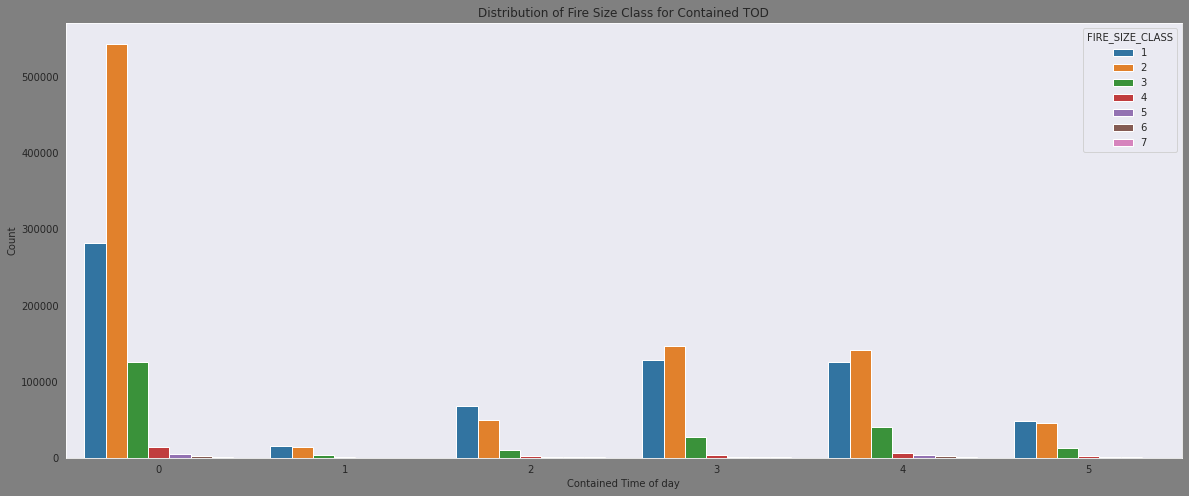

In [54]:
#Graphical Analysis of CONT_TOD
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='CONT_TOD', hue = "FIRE_SIZE_CLASS", data = df) 
plt.xlabel('Contained Time of day')
plt.ylabel('Count')
plt.title('Distribution of Fire Size Class for Contained TOD')
plt.show()

Observations: Same as Discovery time of Day, the count of Containment time of day is maximum for all fire size classes during early morning (12:00 A.M. to 6:00 A.M.)
It is the least during morning hours (1) and is very much similar during the Evening hours (3 and 4)
But due to data imbalance, we cannot see any information about class 7 containment, therefore using the filtered data again (not containing fires of classes 1,2 and 3) for better analysis.

In [55]:
dff = df[df_filtered]

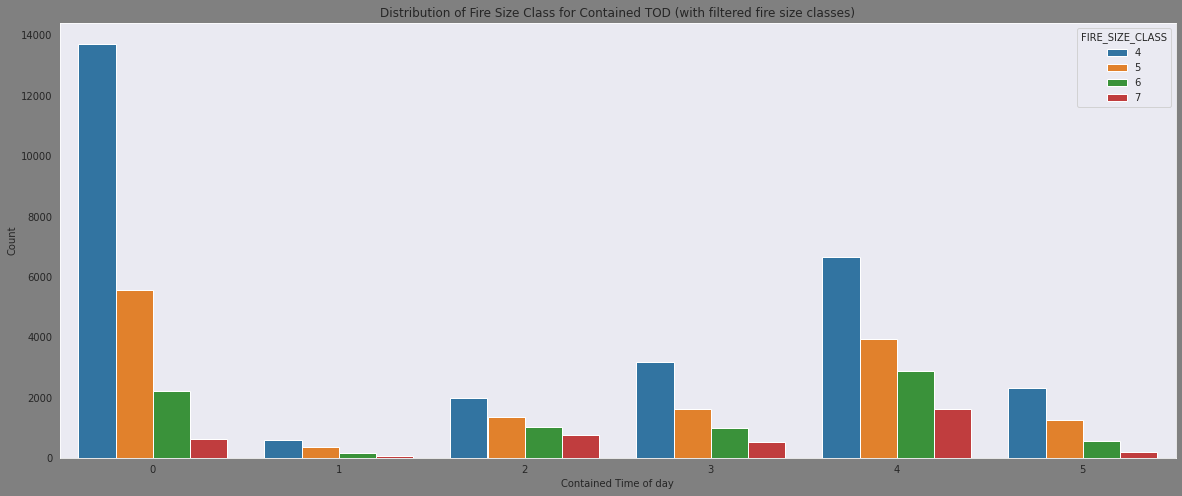

In [56]:
#Graphical Analysis of CONT_TOD for cfire size classes 4,5,6,7.
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='CONT_TOD', hue = "FIRE_SIZE_CLASS", data = dff) 
plt.xlabel('Contained Time of day')
plt.ylabel('Count')
plt.title('Distribution of Fire Size Class for Contained TOD (with filtered fire size classes)')
plt.show()

Observations: The containment time for fires that are huge in size i.e. classes 6 and 7 is between 4:00 P.M. to 8 P.M. 
And for classes below tahn i.e. fire sizes 1,2,3,4,5. The containment time count is maximum in the interval 12:00 A.M. to 6:00 A.M.

In [57]:
del df['CONT_TIME']
df.shape

(1880465, 21)

Next feature is 'FIRE_SIZE'(Feature 28), it is basically the size of the fire spread in acres which is then distributed in classes which we are using as Labels in this study, therefore in real world scenario, FIRE_SIZE is actually the parameter we are predicting, so it can't be used as a feature. 
So, removing it too from our dataframe.

In [58]:
#Feature 28: FIRE_SIZE
del df['FIRE_SIZE']
df.shape

(1880465, 20)

In [ ]:
#Feature 29-30: LATITUDE AND LONGITUDE
#These two features are used together to get the  geographical location of the area of forest fire. Therefore they are very important

print('Unique values for Column LATITUDE are: ', df.LATITUDE.unique())
print('Length of Unique values for Column LATITUDE are: ', len(df.LATITUDE.unique()))
#Check for null values
bool_series = pd.isnull(df['LATITUDE'])
print('Number of null entries for Column LATITUDE are: ', len(df[bool_series]), '\n')

print('Unique values for Column LONGITUDE are: ', df.LONGITUDE.unique())
print('Length of Unique values for Column LONGITUDE are: ', len(df.LONGITUDE.unique()))
#Check for null values
bool_series = pd.isnull(df['LONGITUDE'])
print('Number of null entries for Column LONGITUDE are: ', len(df[bool_series]))


Unique values for Column LATITUDE are:  [40.03694444 38.93305556 38.98416667 ... 40.481637   37.67223469
 34.263217  ]
Length of Unique values for Column LATITUDE are:  894061
Number of null entries for Column LATITUDE are:  0 

Unique values for Column LONGITUDE are:  [-121.00583333 -120.40444444 -120.73555556 ... -122.389375   -120.89835605
 -116.83095   ]
Length of Unique values for Column LONGITUDE are:  997536
Number of null entries for Column LONGITUDE are:  0


For every forest fire, we fortunately have it's coordinate values present.
As we can see, there are a lot of unique values as with increase in the number of decimal points, the precision increases for the location. 
For grouping the nearly forest fires together (for analysis sake), we can round off the values and apply flooring.

In [59]:
df['LATITUDE'] = (df['LATITUDE']*10).apply(np.floor)/10
df['LONGITUDE'] = (df['LONGITUDE']*10).apply(np.floor)/10

In [60]:
#Now creating groups of forest fires which are close geographically
geom_grp = df.groupby(['LATITUDE', 'LONGITUDE'])
wildfires = geom_grp['FIRE_SIZE_CLASS'].agg(['count']).reset_index()
wildfires

LATITUDE  LONGITUDE  count
0          17.9      -67.3     26
1          17.9      -67.2    105
2          17.9      -67.1    212
3          17.9      -67.0    150
4          17.9      -66.9    193
...         ...        ...    ...
68882      69.7     -147.2      1
68883      69.8     -159.3      1
68884      70.1     -151.2      1
68885      70.1     -150.7      1
68886      70.3     -149.6      1

[68887 rows x 3 columns]

In [ ]:
wildfires.describe()

LATITUDE     LONGITUDE         count
count  68887.000000  68887.000000  68887.000000
mean      40.484514   -102.554016     27.297821
std        8.093892     19.023004     60.361540
min       17.900000   -178.900000      1.000000
25%       34.900000   -113.800000      2.000000
50%       39.600000   -100.600000      9.000000
75%       44.400000    -88.900000     30.000000
max       70.300000    -65.300000   4232.000000

In [ ]:
#Code reference: https://www.kaggle.com/oilcorner/wildfire-visualization-heat-maps-literally
source = ColumnDataSource(wildfires)
no_of_wildfires = figure(title="Geographical representation of wildfires in the U.S.(1992-2015)",
           toolbar_location=None, plot_width=600, plot_height=400)
no_of_wildfires.background_fill_color = "black"
no_of_wildfires.grid.grid_line_color = None
no_of_wildfires.axis.visible = False
#Using fire palette already available in cc
color_mapper = LogColorMapper(palette=cc.fire, low=1, high=4232)
glyph = no_of_wildfires.circle('LONGITUDE', 'LATITUDE', source=source,
          color={'field': 'count', 'transform' : color_mapper},
          size=1)
#Legend: color_bar
color_bar = ColorBar(color_mapper=color_mapper,  label_standoff=12, border_line_color=None, ticker=LogTicker(), location=(0,0))
output_notebook()
no_of_wildfires.add_layout(color_bar, 'right')
show(no_of_wildfires)


Lighter color means more wildfires (as given in the legend).
This is a view of all 52 states in the U.S. which include both the continent part and the main land U.S.
To get a better visualization of wildifires in mainland U.S., we can remove the continent states data from our dataframe i.e. states = Hawai, Alaska and Peurto Rico (Reference taken from world map)

In [70]:
heatMapData2 = pd.read_sql_query("SELECT LATITUDE, LONGITUDE, FIRE_SIZE_CLASS, STATE FROM fires WHERE STATE != 'AK' AND  STATE != 'HI'  AND STATE != 'PR'", conn) 

In [ ]:
len(heatMapData2)

1835646

In [73]:
#Truncating Lat Long for grouping the points which are very close together
heatMapData2['LATITUDE'] = (heatMapData2['LATITUDE']*10).apply(np.floor)/10
heatMapData2['LONGITUDE'] = (heatMapData2['LONGITUDE']*10).apply(np.floor)/10

In [74]:
geom_grp2 = heatMapData2.groupby(['LATITUDE', 'LONGITUDE'])
wildfires2 = geom_grp2['FIRE_SIZE_CLASS'].agg(['count']).reset_index()

In [ ]:
wildfires2.describe()

LATITUDE     LONGITUDE         count
count  64250.000000  64250.000000  64250.000000
mean      38.996075    -99.185886     28.570366
std        5.407010     14.309327     60.430750
min       24.500000   -124.800000      1.000000
25%       34.600000   -111.400000      3.000000
50%       39.000000    -99.000000     10.000000
75%       43.600000    -88.000000     32.000000
max       49.300000    -67.000000   4232.000000

In [117]:
#Code reference: https://www.kaggle.com/oilcorner/wildfire-visualization-heat-maps-literally
sourcenew = ColumnDataSource(wildfires2)
no_of_wildfires2 = figure(title="Geographical representation of wildfires in the U.S.(1992-2015)",
           toolbar_location=None, plot_width=600, plot_height=400)
no_of_wildfires2.background_fill_color = "black"
no_of_wildfires2.grid.grid_line_color = None
no_of_wildfires2.axis.visible = False
#Using fire palette already available in cc
color_mapper = LogColorMapper(palette=cc.fire, low=1, high=4232)
glyph = no_of_wildfires2.circle('LONGITUDE', 'LATITUDE', source=sourcenew,
          color={'field': 'count', 'transform' : color_mapper},
          size=1)
color_bar = ColorBar(color_mapper=color_mapper,  label_standoff=12, border_line_color=None, ticker=LogTicker(), location=(0,0))
output_notebook()
no_of_wildfires2.add_layout(color_bar, 'right')
show(no_of_wildfires2)

Observation: This is just the forest fires visualization in U.S. mainland. 
Taking reference from U.S. map, we can see a lot of forest fires in California (left corner)
Regions like Montana, Nebraska, Colorado, Indiana, Illionis have very less cases of forest fires and most of them are darker in shades i.e. the count of forest fires is very less there.
Then again in regions at right bottom corner i.e. Virginia, North and south Carolina, georgia, florida, Alabama there are so many forest fires as the color is very bright and dense. 

We can also represent forest fire counts throughout the years using Folium for better representation through a map.

In [65]:
!pip install folium

In [68]:
from glob import glob
import folium
from folium import plugins
from folium.plugins import HeatMap

In [76]:
#Can change our basemap from this t_list if we wish to
#basemap_list = ["Stamen Terrain", "Stamen Toner", "Mapbox Bright"]
basemap = folium.Map(width=900,height=500,location=[39, -95], zoom_start =4,  tiles = "Stamen Toner")
data =  wildfires2.values.tolist()
HeatMap(data).add_to(folium.FeatureGroup(name='Heat Map').add_to(basemap))
folium.LayerControl().add_to(basemap)
basemap

Observations: This is just a different illustration of Heat Maps depicted above. We can choose the basemap as per our preference based on the list of basemaps present (commented) in the code line. 
Along with zoom in and zoom out features, we also have layer control feature present which is immensly useful when we wish to analyse the geographical locations of an area.
The dense red color represents a large number of wildfires occuring in the region, as the color shades get cooler, means the forest fires are lesser. 
We can zoom in the map for better analysis of each area.

In [ ]:
#Feature 31: OWNER_CODE
print('Unique values for Column OWNER_CODE are: ', df.OWNER_CODE.unique())
print('Length of Unique values for Column OWNER_CODE are: ', len(df.OWNER_CODE.unique()))
#Check for null values
bool_series = pd.isnull(df['OWNER_CODE'])
print('Number of null entries for Column OWNER_CODE are: ', len(df[bool_series]))

Unique values for Column OWNER_CODE are:  [ 5. 13. 14.  6.  2.  4.  9.  8.  7.  1.  3. 10.  0. 12. 11. 15.]
Length of Unique values for Column OWNER_CODE are:  16
Number of null entries for Column OWNER_CODE are:  0


In [ ]:
check_for_nan = df['OWNER_CODE'].isnull().values.any()
print(check_for_nan)

False


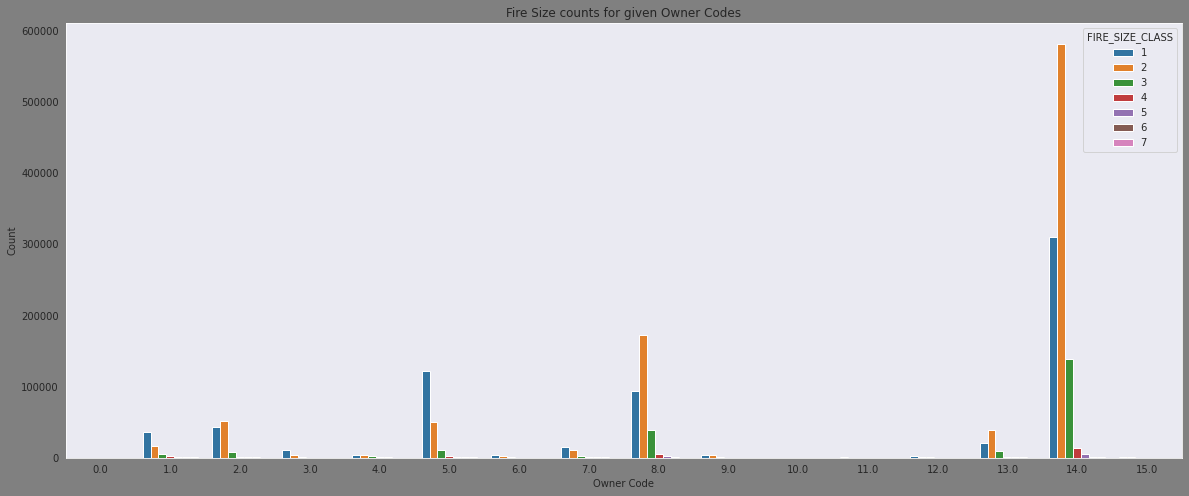

In [ ]:
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='OWNER_CODE', hue = "FIRE_SIZE_CLASS", data = df) 
plt.title('Fire Size counts for given Owner Codes')
plt.xlabel('Owner Code')
plt.ylabel('Count')
plt.show()

Observations: Looking at the graph, we can see that maximum fires occured in area where owner code = 14 (County).
The fire count is almost null when owner code is 0(USFS), 10(NPS), 11(BOR), 15 (Undefined Federal) and very less when 12 (Foreign).

After 14, at Owner code = 8 (State), the fire count is high.

Therefore it seems to be an important feature and should be present.

Since the majority fire classes are dominating in this graph, we will again use the filtering technique for having a closer look at fire size classes 4,5,6,7

In [77]:
dff = df[df_filtered]

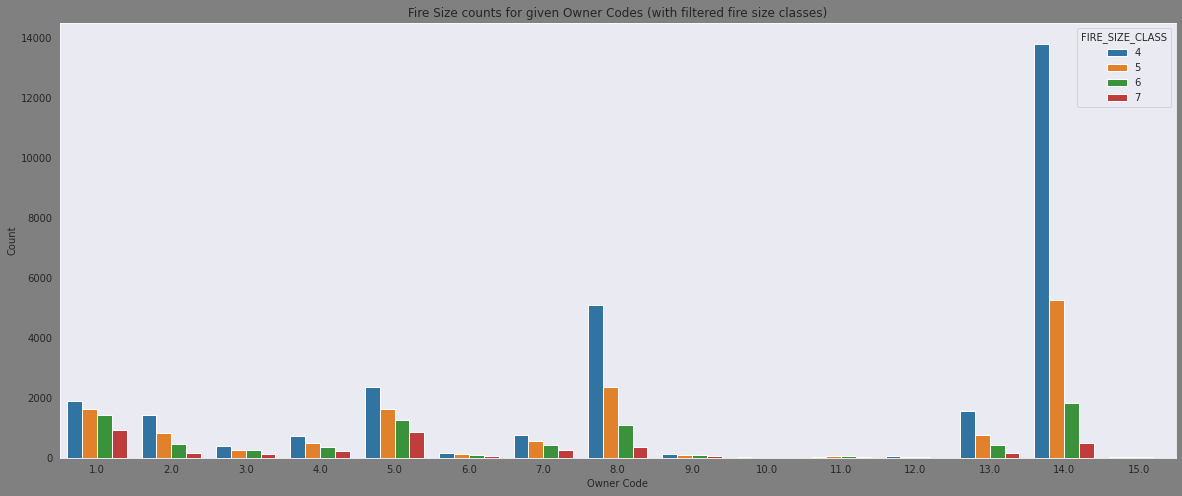

In [79]:
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='OWNER_CODE', hue = "FIRE_SIZE_CLASS", data = dff) 
plt.title('Fire Size counts for given Owner Codes (with filtered fire size classes)')
plt.xlabel('Owner Code')
plt.ylabel('Count')
plt.show()

Observations: Even for fire size classes that are bigger, the count is maximum when owner code is 14.
At owner codes 1, 5 and 8, fires of sizes 5,6 and 7 have a considerably big count.
Therefore this feature is important even for bigger size fires.

In [ ]:
#Feature 32: OWNER_DESCR
print('Unique values for Column OWNER_DESCR are: ', df.OWNER_DESCR.unique())
print('Length of Unique values for Column OWNER_DESCR are: ', len(df.OWNER_DESCR.unique()))
#Check for null values
bool_series = pd.isnull(df['OWNER_DESCR'])
print('Number of null entries for Column OWNER_DESCR are: ', len(df[bool_series]))

Unique values for Column OWNER_DESCR are:  ['USFS' 'STATE OR PRIVATE' 'MISSING/NOT SPECIFIED' 'OTHER FEDERAL' 'BIA'
 'FWS' 'TRIBAL' 'PRIVATE' 'STATE' 'BLM' 'NPS' 'BOR' 'FOREIGN'
 'MUNICIPAL/LOCAL' 'COUNTY' 'UNDEFINED FEDERAL']
Length of Unique values for Column OWNER_DESCR are:  16
Number of null entries for Column OWNER_DESCR are:  0


Again this is just the same feature as OWNER_CODE with only different that it is in text form, therefore not required.


In [80]:
del df['OWNER_DESCR']
df.shape

(1880465, 19)

In [ ]:
#Feature 33: STATE 
print('Unique values for Column STATE are: ', df.STATE.unique())
print('Length of Unique values for Column STATE are: ', len(df.STATE.unique()))
#Check for null values
bool_series = pd.isnull(df['STATE'])
print('Number of null entries for Column STATE are: ', len(df[bool_series]))

Unique values for Column STATE are:  ['CA' 'NM' 'OR' 'NC' 'WY' 'CO' 'WA' 'MT' 'UT' 'AZ' 'SD' 'AR' 'NV' 'ID'
 'MN' 'TX' 'FL' 'SC' 'LA' 'OK' 'KS' 'MO' 'NE' 'MI' 'KY' 'OH' 'IN' 'VA'
 'IL' 'TN' 'GA' 'AK' 'ND' 'WV' 'WI' 'AL' 'NH' 'PA' 'MS' 'ME' 'VT' 'NY'
 'IA' 'DC' 'MD' 'CT' 'MA' 'NJ' 'HI' 'DE' 'PR' 'RI']
Length of Unique values for Column STATE are:  52
Number of null entries for Column STATE are:  0


Knowing the state where the forest fire has occured, we can get information about the average temperature and average precipitation of that state which are important features for fining the probable area spread of forest fire.
Manually Encoding states according to alphabatical order.


In [93]:
df['STATE'] = df['STATE'].map({
'AL': 0, 
'AK': 1, 
'AZ': 2, 
'AR': 3, 
'CA': 4, 
'CO': 5,
'CT': 6,
'DE': 7,
'DC': 8,
'FL': 9,
'GA': 10,
'HI': 11,
'ID': 12,
'IL': 13,
'IN': 14,
'IA': 15,
'KS': 16,
'KY': 17,
'LA': 18,
'ME': 19,
'MD': 20,
'MA': 21,
'MI': 22,
'MN': 23,
'MS': 24,
'MO': 25,
'MT': 26,
'NE': 27,
'NV': 28,
'NH': 29,
'NJ': 30,
'NM': 31,
'NY': 32,
'NC': 33,
'ND': 34,
'OH': 35,
'OK': 36,
'OR': 37,
'PA': 38,
'PR': 39,
'RI': 40,
'SC': 41,
'SD': 42,
'TN': 43,
'TX': 44,
'UT': 45,
'VT': 46,
'VA': 47,
'WA': 48,
'WV': 49,
'WI': 50,
'WY': 51}) 
df['STATE'].astype('int64')

0          4
1          4
2          4
3          4
4          4
          ..
1880460    4
1880461    4
1880462    4
1880463    4
1880464    4
Name: STATE, Length: 1880465, dtype: int64

Now that states have been encoded, we will be using data from excel files (Self created by fetching values from online sources mensioned with each excel) to create new features based on states and year of fire occurance.

In [83]:
#1st Getting State Wise forest coverage 
#Source for Data: https://en.wikipedia.org/wiki/Forest_cover_by_state_and_territory_in_the_United_States
#Compilation done in Microsoft Excel.. file added in google drive 

forest_Area = pd.read_excel('drive/My Drive/CaseStudy1/FOREST_Area.xlsx')

In [ ]:
forest_Area.head()

State  State_label  Forest_Coverage
0    AL            0            70.57
1    AK            1            35.16
2    AZ            2            25.64
3    AR            3            56.31
4    CA            4            32.71

In [ ]:
#Since the index of the rows is same as the key value, therefore: 
STATE_PRCNT_FOREST = [];
for i in range(len(df)):
  key = df.iloc[i]['STATE']
  STATE_PRCNT_FOREST.append(forest_Area['Forest_Coverage'].values[key])


In [ ]:
print(len(STATE_PRCNT_FOREST))

1880465


In [ ]:
df['STATE_PRCNT_FOREST'] = STATE_PRCNT_FOREST
df['STATE_PRCNT_FOREST'].astype('float64')

0          32.71
1          32.71
2          32.71
3          32.71
4          32.71
           ...  
1880460    32.71
1880461    32.71
1880462    32.71
1880463    32.71
1880464    32.71
Name: STATE_PRCNT_FOREST, Length: 1880465, dtype: float64

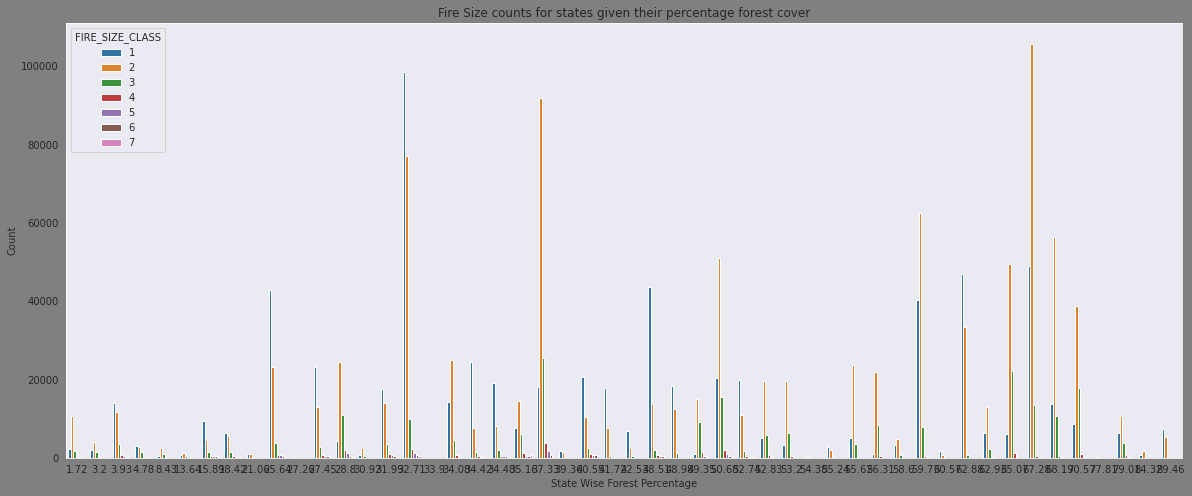

In [ ]:
#Doing Graphical Analysis 
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='STATE_PRCNT_FOREST',  hue = "FIRE_SIZE_CLASS", data = df) 
plt.title('Fire Size counts for states given their percentage forest cover')
plt.xlabel('State Wise Forest Percentage')
plt.ylabel('Count')
plt.show()

Observations: We can see that with increase in the forest area percentage there is a prominent increase in forest fire counts too, but there are exceptions for fires of smaller classes. Since the graph is hard to follow because of the large number of values on X-axis. Dividing the data into two parts based on forest percentage area wise and then analysing each part.

In [ ]:
#Using describe function to get a mid value of this feature
df['STATE_PRCNT_FOREST'].describe()

count    1.880465e+06
mean     4.726189e+01
std      1.755034e+01
min      1.720000e+00
25%      3.271000e+01
50%      4.935000e+01
75%      6.288000e+01
max      8.946000e+01
Name: STATE_PRCNT_FOREST, dtype: float64

In [ ]:
df_filtered2 = (df["STATE_PRCNT_FOREST"] < 47)
dff2 = df[df_filtered2]

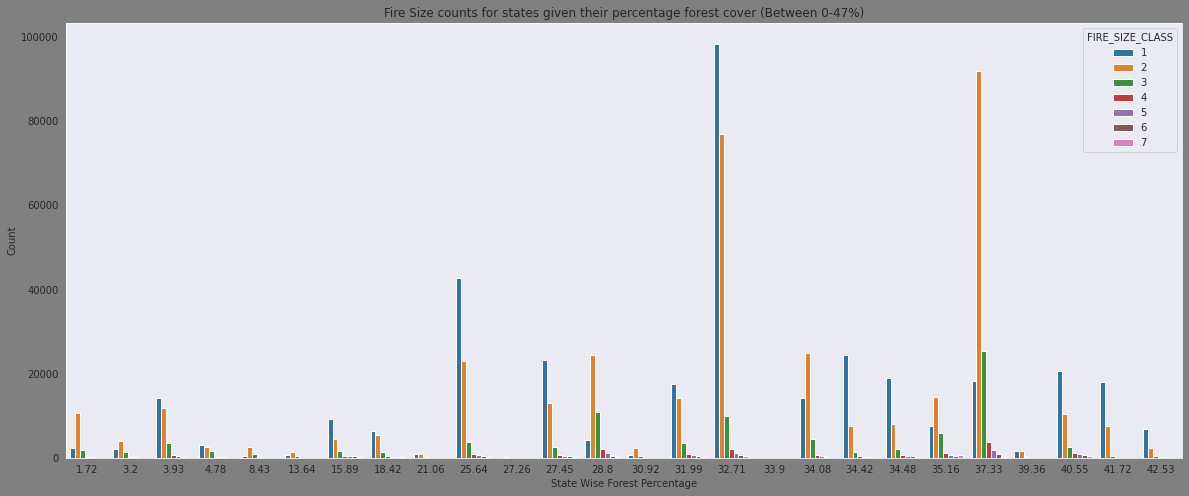

In [ ]:
#Doing Graphical Analysis 
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='STATE_PRCNT_FOREST',  hue = "FIRE_SIZE_CLASS", data = dff2) 
plt.title('Fire Size counts for states given their percentage forest cover (Between 0-47%)')
plt.xlabel('State Wise Forest Percentage')
plt.ylabel('Count')
plt.show()

Observations: When the percentage forest area of a state is small i.e. < 20% , the number of fire occurances of any fire size class is very low. 
As the percentage increases, the fire incidents counts are also increasing gradually except for some cases where there is a sudden spike in the count e.g. at area 25.64 which on looking at the excel sheet is for the state of Arizona (AZ), similarly at 32.71 (California) , 37.33(Texas).

These exceptions can be a result of other hidden parameters.


In [ ]:
#Looking at the remaining data
df_filtered3 = (df["STATE_PRCNT_FOREST"] >= 47)
dff3 = df[df_filtered3]

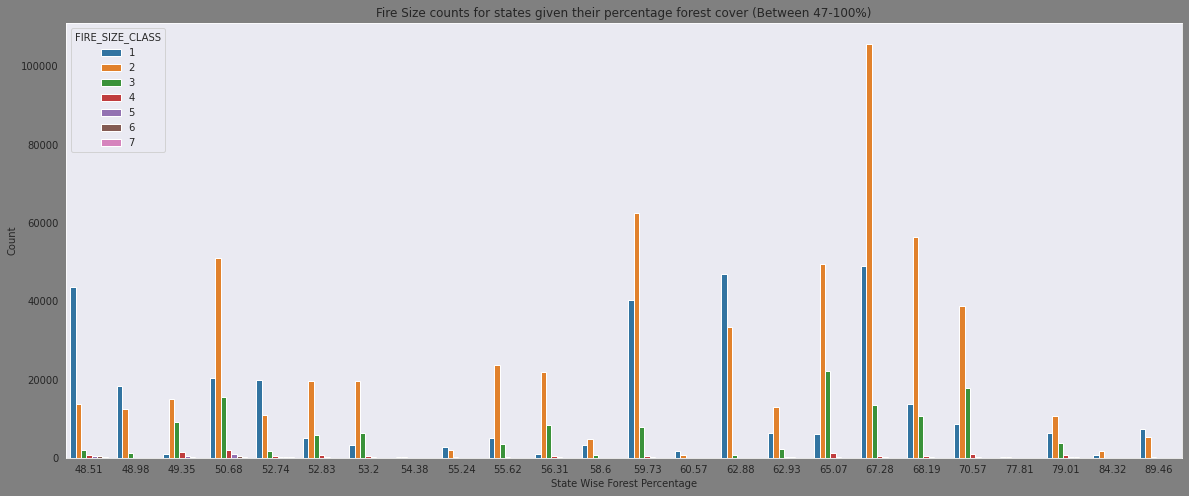

In [ ]:
#Doing Graphical Analysis 
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='STATE_PRCNT_FOREST',  hue = "FIRE_SIZE_CLASS", data = dff3) 
plt.title('Fire Size counts for states given their percentage forest cover (Between 47-100%)')
plt.xlabel('State Wise Forest Percentage')
plt.ylabel('Count')
plt.show()

Observations: With the increase in the percentage value, an increase in forest fire count can easily be seen for fire classes 1 and 2.
There are a few acceptions such as when size is 54.38 (State of Rhode Island) and then at 60.57 (Massachusettes). 
When the percentage gets greater than 75%, the fire count has suddenly fallen. 
Looking at the states for better understanding:
1. Area 77.81% : Vermont
2. Area 79.01%: West Virginia
3. Area 84.32%: New Jersey
4. Area 89.46%: Maine

On looking at the U.S. Map, we observed that all 4 states are located at the East corner of the country (Towards the Atlantic Ocean) and are very small in area compared to other states.
These common features can be responsible for some factors which lead to lesser forest fires in these areas.

Now we are introducing another important feature: Average Temperature which would take into account both 'STATE' an the 'FIRE_YEAR' features.

In [94]:
#Data created in Microsoft Excel.
#Year wise temperature values for each state taken from: https://www.ncdc.noaa.gov/cag/statewide
avg_temp  = pd.read_excel('drive/My Drive/CaseStudy1/avg_temp.xlsx')

In [95]:
#Here the annual average temperature values are provided year wise
avg_temp.head()

State_Label State  1992  1993  1994  ...  2011  2012  2013  2014  2015
0            0    AL  62.1  62.3  63.0  ...  63.8  64.9  62.6  62.0  64.6
1            1    AK  25.0  29.9  26.2  ...  27.0  24.3  27.8  30.3  30.0
2            2    AZ  59.6  59.8  60.6  ...  60.3  62.1  60.4  62.2  61.8
3            3    AR  59.9  59.3  60.4  ...  61.8  63.6  59.6  58.7  61.4
4            4    CA  59.3  57.7  58.0  ...  57.4  59.5  59.3  61.4  60.8

[5 rows x 26 columns]

In [96]:
#Adding this 'avg_temp' dataset values to create a row as per state and year value for average temperature
AVG_TEMP_LIST = [];
for i in range(len(df)):
  state_key = df.iloc[i]['STATE']
  year_key = df.iloc[i]['FIRE_YEAR']
  AVG_TEMP_LIST.append(avg_temp[year_key].values[state_key])

In [97]:
len(AVG_TEMP_LIST)

1880465

In [98]:
df['AVG_TEMP'] = AVG_TEMP_LIST
df['AVG_TEMP'].astype('float64')

0          58.6
1          58.9
2          58.9
3          58.9
4          58.9
           ... 
1880460    60.8
1880461    60.8
1880462    60.8
1880463    60.8
1880464    60.8
Name: AVG_TEMP, Length: 1880465, dtype: float64

Since we now have the temperature values both state wise and year wise, we can perform analysis on it accordingly.
1st performing analysis Year wise

In [107]:
df_filtered = (df["FIRE_YEAR"] == 1992) 

In [108]:
dff = df[df_filtered]

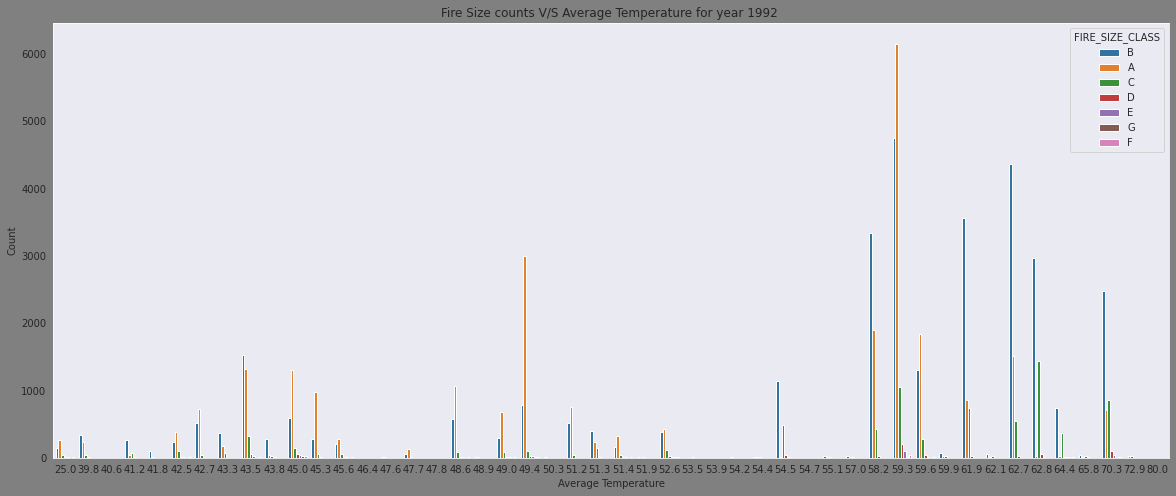

In [109]:
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='AVG_TEMP',  hue = "FIRE_SIZE_CLASS", data = dff) 
plt.title('Fire Size counts V/S Average Temperature for year 1992 ')
plt.xlabel('Average Temperature')
plt.ylabel('Count')
plt.show()

Observations: This data is specific to year 1992 i.e. the state wise Avergae Temperatures and the forest fires are of year 1992.
With an increase in temperature, we can observe that there is an increase in fire occurances for all classes. 
Between temperatures 52.6 - 57 degree fahrenheit, we can observe a sudden decrease on forest fire counts of all classes.
This behaviour can be specific to this certain year (1992) and might have some other hidden factors attached to it.



In [104]:
df_filtered2 = (df["FIRE_YEAR"] == 2005) 
dff2 = df[df_filtered2]

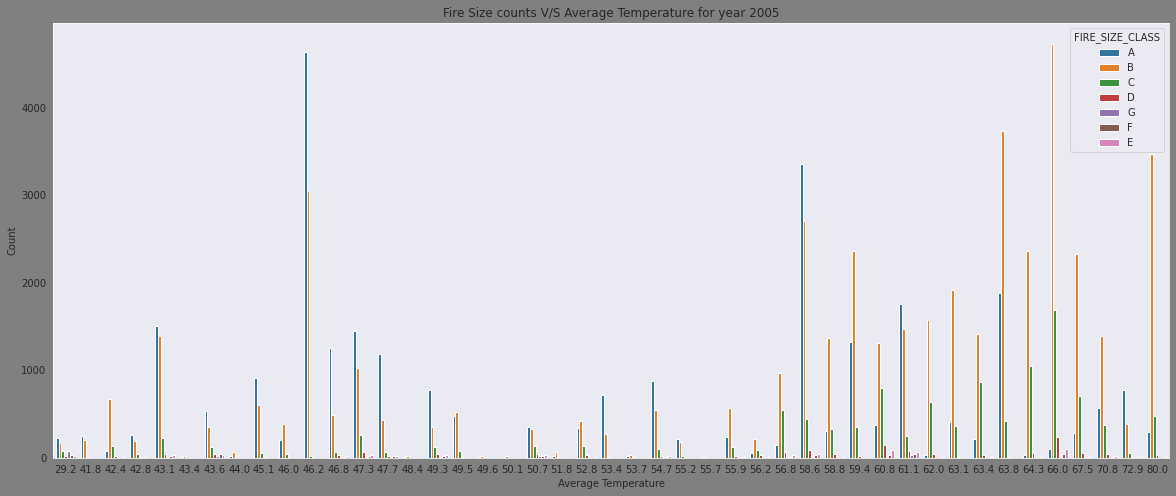

In [106]:
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='AVG_TEMP',  hue = "FIRE_SIZE_CLASS", data = dff2) 
plt.title('Fire Size counts V/S Average Temperature for year 2005')
plt.xlabel('Average Temperature')
plt.ylabel('Count')
plt.show()

Observations: This graph is similar to the above graph which was for year 1995. The observations are similar too i.e. for year 2005 too, with increase in temperature the fire incidents are increasing. Therefore we can say that it is a generic behaviour and not something specific to a particular year.
Now analysing the same feature in terms of different states.

In [110]:
#Analysing State wise too
df_filtered3 = (df["STATE"] == 5) 
dff3 = df[df_filtered3]

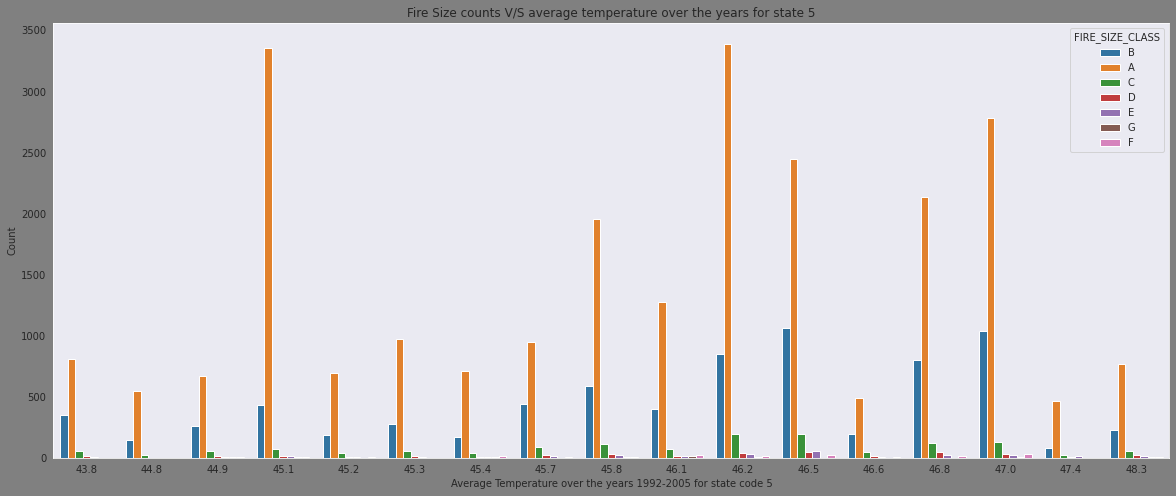

In [111]:
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='AVG_TEMP',  hue = "FIRE_SIZE_CLASS", data = dff3) 
plt.title('Fire Size counts V/S average temperature over the years for state 5')
plt.xlabel('Average Temperature over the years 1992-2005 for state code 5')
plt.ylabel('Count')
plt.show()

Observations: This is a graph of change in Counts of different fire sizes for state label = 5 (Colorado).
Here also we can observe that than as the teperature is rising (between 45.8-47.0 degree fahrenheits) for this particular state, there is an increase in fire count for all size classes (Even the large ones).

In [114]:
df_filtered4 = (df["STATE"] == 42) 
dff4 = df[df_filtered4]

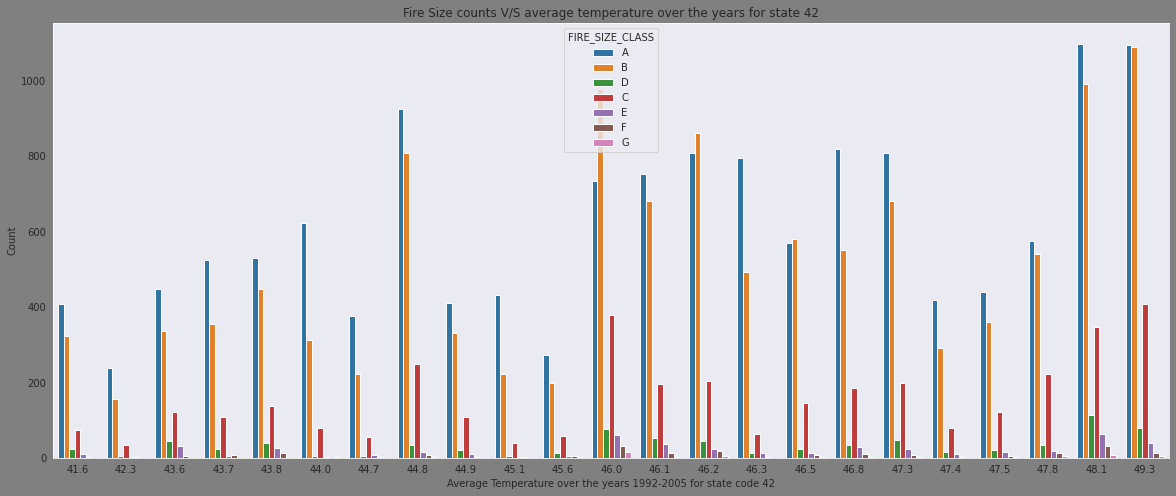

In [115]:
plt.figure(figsize=(20,8), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='AVG_TEMP',  hue = "FIRE_SIZE_CLASS", data = dff4) 
plt.title('Fire Size counts V/S average temperature over the years for state 42')
plt.xlabel('Average Temperature over the years 1992-2005 for state code 42')
plt.ylabel('Count')
plt.show()

Observations: Here the graph is created of Average temperature V/S Forest Fire count for the State label 42 (South Dakota)
Here also for the years where average temperature is higher like 46 degree fahrenheits and above, the counts of forest fires for all of the fire size classes have increased. 

Therefore average temperature is an important feature an it directly effects the forest fires probability.

In [116]:
#ADDING PRECIPITATION FEATURE
avg_prec  = pd.read_excel('drive/My Drive/CaseStudy1/avg_prec.xlsx')

In [ ]:
avg_prec.head()

State_Label State  Avg_Prec
0            0    AL     56.00
1            1    AK     29.03
2            2    AZ     11.80
3            3    AR     49.72
4            4    CA     22.97

In [ ]:
AVG_PREC_LIST = [];
for i in range(len(df)):
  state_key = df.iloc[i]['STATE']
  AVG_PREC_LIST.append(avg_prec['Avg_Prec'].values[state_key])

In [ ]:
df['AVG_PREC'] = AVG_PREC_LIST
df['AVG_PREC'].astype('float64')

0          22.97
1          22.97
2          22.97
3          22.97
4          22.97
           ...  
1880460    22.97
1880461    22.97
1880462    22.97
1880463    22.97
1880464    22.97
Name: AVG_PREC, Length: 1880465, dtype: float64

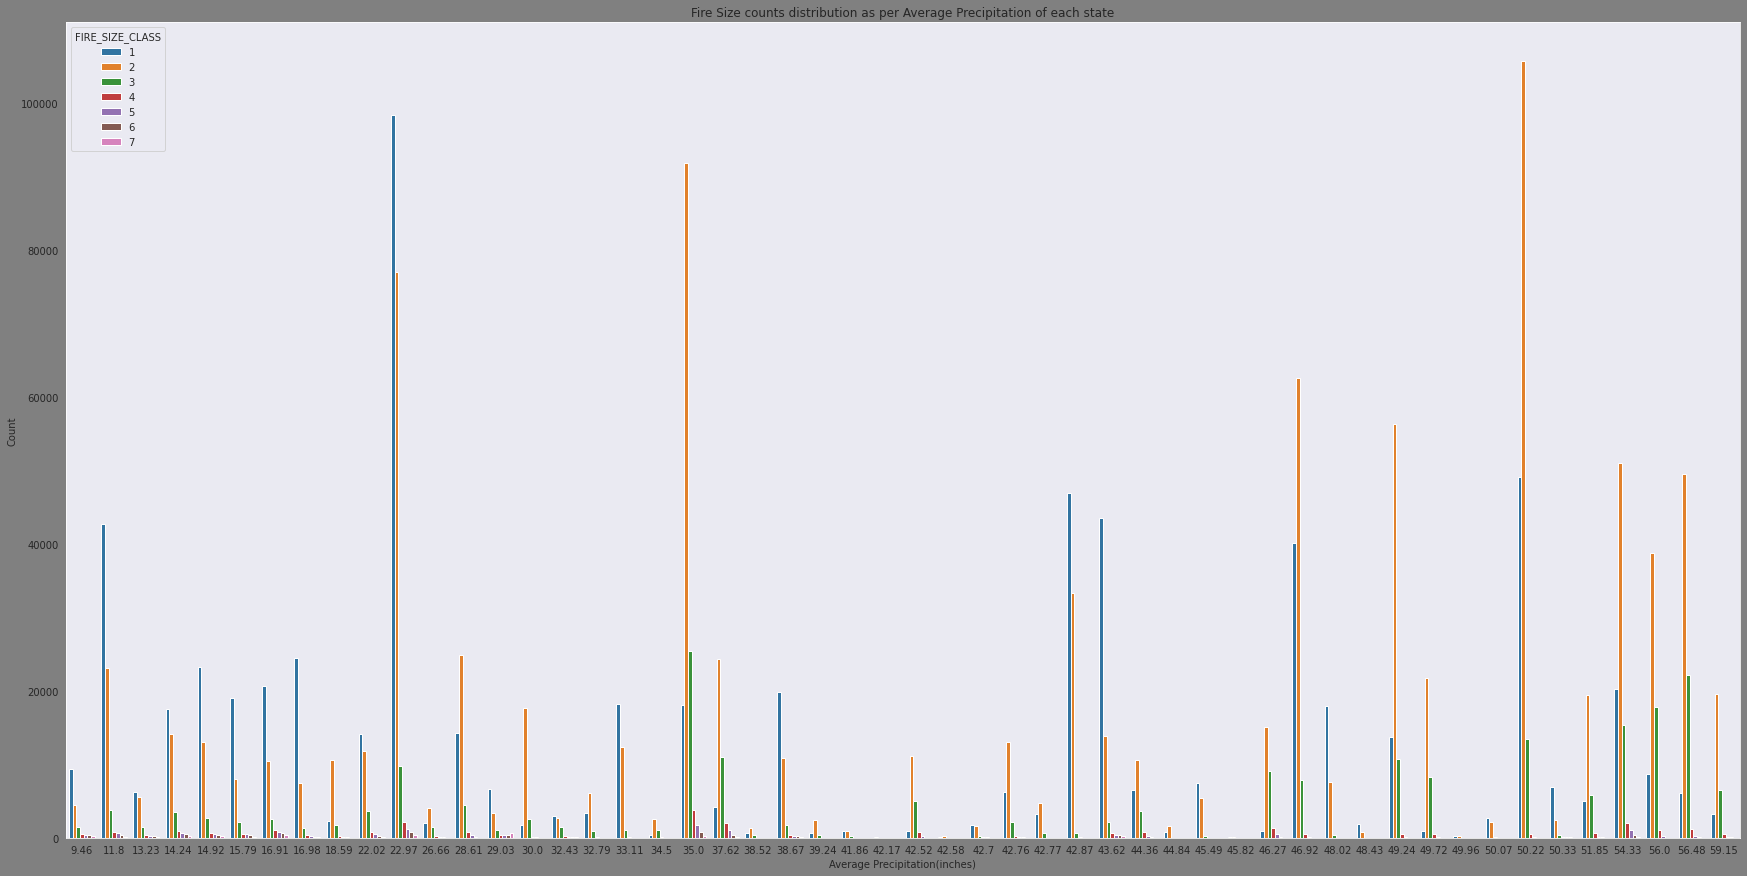

In [ ]:
#then analysing the AVG_PREC feature graphically
plt.figure(figsize=(30,15), facecolor='grey')
sns.set_style("dark")
sns.countplot(x ='AVG_PREC', hue = "FIRE_SIZE_CLASS", data = df) 
plt.title('Fire Size counts distribution as per Average Precipitation of each state')
plt.xlabel('Average Precipitation(inches)')
plt.ylabel('Count')
plt.show()

Observations: For certain precipitation values, we can see a sudden spike in forest fires (but mostly the spiked fire classes are of class 2 so it can also be due to imbalance in the data).
! important observation from this figure can be, during the initial precipitation range i.e. between 9.46-29.03 inches, we can see that the count of forest fires with bigger sizes is actually higher compared to others and also considering that there isn't much data available for these classes.
Therefore Precipitation is an important feature for classification.

Observations: We can see that for some states, like 4, 10, 44 etc. the count of forest fires is really high 
For state 4, we can see all 7 forest fire classes therefore we can predict that the forest fires are both regular and can vary in all sizes, similarly state 44. Therefore better mitigation arrangements should be made in these states before anywhere else. 
In states such as 7, 8,44, 47 there are null/very less forest fires. Therefire they are comparitively safer. 
This feature provides a lot of information about the probable forest fire size and is therefore important.

Observations: As the Average temperature is increasing, the fire counts are increasing too other than a few exceptions. Therefore temperature is a useful parameter in getting the probable fire size class. 
we can see a sudden hike in fire counts when temperature goes beyond 58 degrees fahreheit.

In [ ]:
#Feature 32: COUNTY: administrative/political sub division
print('Unique values for Column COUNTY are: ', df.COUNTY.unique())
print('Length of Unique values for Column COUNTY are: ', len(df.COUNTY.unique()))
#Check for null values
bool_series = pd.isnull(df['COUNTY'])
print('Number of null entries for Column COUNTY are: ', len(df[bool_series]))
#Number for features which aren't null
bool_series2 = pd.notnull(df['COUNTY'])
print('Number of non- null entries for Column COUNTY are: ', len(df[bool_series2]))

Unique values for Column COUNTY are:  ['63' '61' '17' ... 'Oahu' 'Molokaii' 'Lanai']
Length of Unique values for Column COUNTY are:  3456
Number of null entries for Column COUNTY are:  678148
Number of non- null entries for Column COUNTY are:  1202317


The county feature have a large number of null values and it's unique value count is also very hugh. Moreover, the data provided for this feature contains both Text and Numeric Data. Therefore the data does not seem to be trustworthy enough, hence removing it as a feature.

In [ ]:
del df['COUNTY']
df.shape

(1880465, 20)

In [ ]:
#Feature 33: FIPS_CODE
#Defination(Source: wikipedia):
#The Federal Information Processing Standard Publication 6-4 (FIPS 6-4) was a five-digit Federal Information Processing Standards code which
#uniquely identified counties and county equivalents in the United States, certain U.S. possessions, and certain freely associated states.
print('Unique values for Column FIPS_CODE are: ', df.FIPS_CODE.unique())
print('Length of Unique values for Column FIPS_CODE are: ', len(df.FIPS_CODE.unique()))
#Check for null values
bool_series = pd.isnull(df['FIPS_CODE'])
print('Number of null entries for Column FIPS_CODE are: ', len(df[bool_series]))

Unique values for Column FIPS_CODE are:  ['063' '061' '017' '003' '005' None '027' '021' '113' '011' '009' '069'
 '037' '033' '053' '089' '049' '019' '023' '103' '043' '051' '039' '013'
 '025' '047' '031' '510' '007' '057' '001' '137' '091' '081' '071' '015'
 '035' '129' '006' '029' '075' '087' '065' '095' '105' '093' '055' '221'
 '059' '067' '165' '213' '153' '209' '123' '215' '077' '085' '169' '161'
 '045' '229' '041' '079' '028' '115' '107' '235' '109' '101' '147' '131'
 '099' '173' '181' '149' '203' '223' '125' '175' '179' '117' '097' '205'
 '163' '187' '195' '127' '151' '197' '083' '199' '122' '261' '291' '133'
 '237' '311' '241' '313' '121' '111' '073' '171' '257' '135' '119' '280'
 '110' '220' '130' '157' '201' '139' '281' '295' '189' '159' '141' '167'
 '145' '155' '339' '225' '471' '497' '407' '143' '020' '211' '403' '405'
 '419' '455' '347' '185' '193' '012' '177' '239' '243' '249' '259' '263'
 '269' '273' '307' '217' '219' '247' '297' '253' '275' '271' '279' '283'
 '309' '315

It is again just an identification code and not a parameter related to forest fire size. Moreover it has a lot of null values and the null values cannot be just replaced by random numbers as the identification codes are uniquely assigned.
Hence not using it as a feature

In [ ]:
del df['FIPS_CODE']
df.shape

(1880465, 19)

In [ ]:
#Feature 34: FIPS_NAME
print('Unique values for Column FIPS_NAME are: ', df.FIPS_NAME.unique())
print('Length of Unique values for Column FIPS_NAME are: ', len(df.FIPS_NAME.unique()))
#Check for null values
bool_series = pd.isnull(df['FIPS_NAME'])
print('Number of null entries for Column FIPS_NAME are: ', len(df[bool_series]))

Unique values for Column FIPS_NAME are:  ['Plumas' 'Placer' 'El Dorado' ... "O'Brien" 'Gurabo Municipio' 'Garvin']
Length of Unique values for Column FIPS_NAME are:  1699
Number of null entries for Column FIPS_NAME are:  678148


FIPS Codes and Name are important geographic characteristics but they are unique for every area (much like Zip Codes in India). Therefore we cannot just assign any numerical value for them. So we can use One hot Encoding instead. But the dimensionality of our model will increase tremendeously in that case and moreove there are a huge number of rows where we do not have FIPS information (678148).
Therefore not using it for our final dataset.


In [ ]:
del df['FIPS_NAME']
df.shape

(1880465, 18)

In [ ]:

#Feature 35: Shape
print('Unique values for Column Shape are: ', df.Shape.unique())
print('Length of Unique values for Column Shape are: ', len(df.Shape.unique()))
#Check for null values
bool_series = pd.isnull(df['Shape'])
print('Number of null entries for Column Shape are: ', len(df[bool_series]))

Unique values for Column Shape are:  [b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@|\x01\x00\x00\x00\xe8d\xc2\x92_@^\xc0\xe0\xc8l\x98\xba\x04D@\xfe'
 b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\xc0\x90\xc6U]nwC@T\xb6\xeej\xe2\x19^\xc0\x90\xc6U]nwC@|\x01\x00\x00\x00T\xb6\xeej\xe2\x19^\xc0\x90\xc6U]nwC@\xfe'
 b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\xc0P\xbbf,\xf9}C@\xd0\xa5\xa0W\x13/^\xc0P\xbbf,\xf9}C@|\x01\x00\x00\x00\xd0\xa5\xa0W\x13/^\xc0P\xbbf,\xf9}C@\xfe'
 ...
 b'\x00\x01\xad\x10\x00\x00P\xb8\x1e\x85\xeb\x98^\xc0\x98\xc5\xfdG\xa6=D@P\xb8\x1e\x85\xeb\x98^\xc0\x98\xc5\xfdG\xa6=D@|\x01\x00\x00\x00P\xb8\x1e\x85\xeb\x98^\xc0\x98\xc5\xfdG\xa6=D@\xfe'
 b'\x00\x01\xad\x10\x00\x00x\xba_\xaa~9^\xc0\xb8dL\xc9\x0b\xd6B@x\xba_\xaa~9^\xc0\xb8dL\xc9\x0b\xd6B@|\x01\x00\x00\x00x\xba_\xaa~9^\xc0\xb8dL\xc9\x0b\xd6B@\xfe'
 b'\x00\x01\xad\x10\x00\x00\x1c\xa7\xe8H.5]\xc00`;\x18\xb1!A@\x1c\xa7\xe8H.5]\xc00`;\x18\xb1!A@|\x01\x00\x00

This feature (Shape) is unique for 90%  of the features and does not contribute in forest fire size prediction therefore it can be removed.

In [ ]:
del df['Shape']
df.shape

(1880465, 17)

In [ ]:
df.head()

SOURCE_SYSTEM_TYPE  SOURCE_SYSTEM  ...  AVG_TEMP  AVG_PREC
0                   0              2  ...      58.6     22.97
1                   0              2  ...      58.9     22.97
2                   0              2  ...      58.9     22.97
3                   0              2  ...      58.9     22.97
4                   0              2  ...      58.9     22.97

[5 rows x 17 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SOURCE_SYSTEM_TYPE     int64  
 1   SOURCE_SYSTEM          int64  
 2   NWCG_REPORTING_AGENCY  int64  
 3   FIRE_YEAR              int64  
 4   DISCOVERY_DOY          int64  
 5   STAT_CAUSE_CODE        float64
 6   CONT_DOY               float64
 7   FIRE_SIZE_CLASS        int64  
 8   LATITUDE               float64
 9   LONGITUDE              float64
 10  OWNER_CODE             float64
 11  STATE                  int64  
 12  DISCOVERY_MONTH        int64  
 13  DISCOVERY_TOD          int64  
 14  CONT_TOD               int64  
 15  AVG_TEMP               float64
 16  AVG_PREC               float64
dtypes: float64(7), int64(10)
memory usage: 243.9 MB


#Individual feature analysis completed

Using Correlation Matrix to understand how strong the relation is between the final features

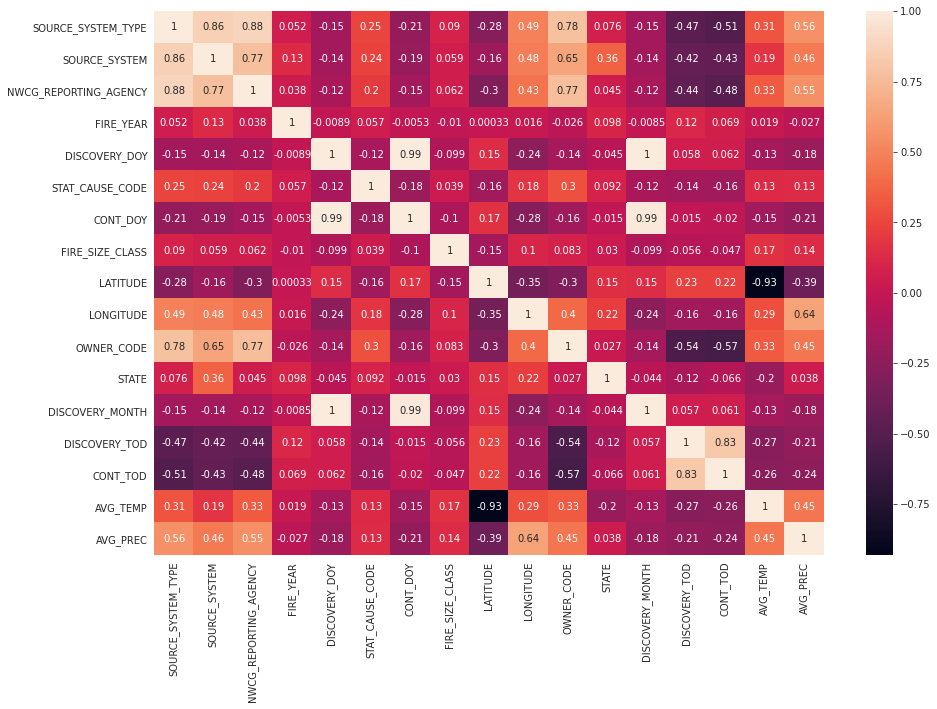

In [ ]:
plt.figure(figsize=(15,10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

Observations: The final features are not much correlated to each other (as higher correlation means that the features are not adding much value to the model). The least correlated the features are, the better is the model. 
Most of the features are doing fine except for:
1. DISCOVERY_DOY AND DISCOVERY_MONTH
2. CONT_DOY AND DISCOVERY_MONTH
3. DISCOVERY_DOY AND CONT_DOY

Since we have already extracted the month features from DOY features, we can remove both 'DISCOVERY_DOY' and 'CONT_DOY' as they are not adding any value to our features list.

On logically anaylysing the real worl scenario, we won't be having the containment time of day pre hand as we will be determining the fire size before it is contained, therefore we would remove that feature too. 

In [ ]:
del df['DISCOVERY_DOY']
del df['CONT_DOY']

In [ ]:
del df['CONT_TOD']
df.shape

(1880465, 14)

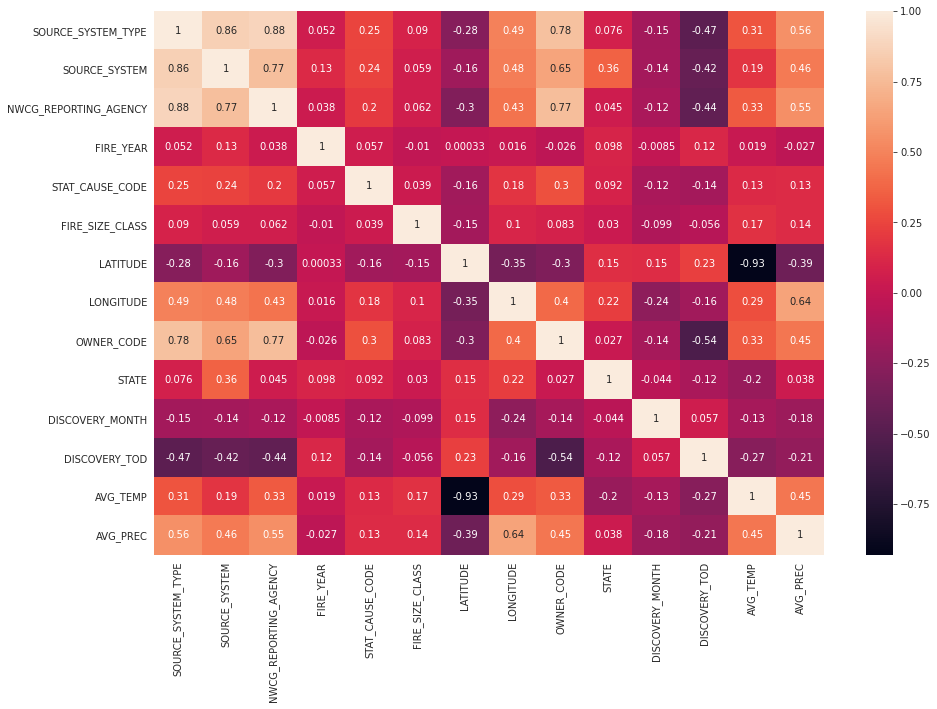

In [ ]:
#Viewing the Correlation matrix again
plt.figure(figsize=(15,10))
corr_matrix2 = df.corr()
sns.heatmap(corr_matrix2, annot=True)
plt.show()

We can see that 'Latitude' and 'AVG_TEMP' features are inversely corelated but the relation is natural as with increase in latitude values, the temperature values decreases. 
The matrix now gives much better results, so these features can now be used for training a model.
At the end of the EDA, we are left with a dataframe of size (1880465, 14) which would be used further.

In [ ]:
#Storing the final dataframe in a pickle file to prevent re computations in the future.
df.to_pickle('drive/My Drive/caseStudy1.pkl')